In [37]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import re
import random



today = datetime.today().strftime('%Y-%m-%d')

pd.set_option('display.max_rows', 100)

from IPython.display import display, HTML    # make the screen bigger!
display(HTML(data=""" <style>    div#notebook-container    { width: 95%; }    div#menubar-container    
{ width: 85%; }    div#maintoolbar-container { width: 99%; } </style> """))    



In [38]:
# List out the standards not actual analytes
standards = ["Dibromofluoromethane (SS1)", "IS1 Pentafluorobenzene", "IS2 1,4-Difluorobenzene",
            "Toluene-d8 (SS2)", "IS3 Chlorobenzene-d5", "1-Bromo-4-fluorobenzene (BFB,SS3)", 
            "IS4 1,4-Dichlorobenzene-d4", 'Dibromofluoromethane [SS1]', 'Pentafluorobenzene [IS1]', 
             '1,4-Difluorobenzene [IS2]', 'Toluene-d8 [SS2]', 'Chlorobenzene-d5 [IS3]', 
             '1-Bromo-4-fluorobenzene (BFB) [SS3]', '1,4-Dichlorobenzene-d4 [IS4]']

# Functions 


Data format notes Catherines data needs to be reformatted as: 
Col 1 = "Peak" 
Col 2 = "Reporting_Limit"
Col 3-... Sample Names   (Be sure they are named the same way as in the sheet 

In [39]:
# Read in the VOC Health Limits File
def Read_in_Limits_FileCSV(Limits_File, Limits_Peak_col_name, standards):

    # Read the file 
    limits = pd.read_csv(Limits_File)
    limits[Limits_Peak_col_name] = limits[Limits_Peak_col_name].str.strip()   # Pull out whitespace in column names

    #Clean up to just 3 limits
    limits = limits[[Limits_Peak_col_name, "EPA MCLG", 'EPA MCL','Short-term', 'Chronic']]
    
    # Drop rows that are the standards 
    limits = limits[~limits[Limits_Peak_col_name].isin(standards)]   
    
    limits["EPA MCLG"] = pd.to_numeric(limits["EPA MCLG"], errors='coerce')
    limits["EPA MCL"] = pd.to_numeric(limits["EPA MCL"], errors='coerce')
    limits["Short-term"] = pd.to_numeric(limits["Short-term"], errors='coerce')
    limits["Chronic"] = pd.to_numeric(limits["Chronic"], errors='coerce')
    
    return limits



# Read in Data files formatted like #2 excel file samples on samples tab
def Round_3_data_read(dataFile, PeakColName):
    
    AllData = pd.read_csv(os.path.join("..", "Clean_Data", dataFile))
    AllData[PeakColName] = AllData[PeakColName].str.strip()   # Pull out whitespace in column names
    
    # Drop rows that are the standards 
    AllData = AllData[~AllData[PeakColName].isin(standards)]   
    
    return AllData




## extract out the values for the total trihalomethanes and give a number 

def TTHM_Calculator(Samp_name, SampData):
    TTHM_List = ['Bromodichloromethane', 'Bromoform', 'Dibromochloromethane', "Trichloromethane (chloroform)"]
    empty_List = []    
    
    for i in TTHM_List: 
        # Pull out the value of each one of the TTHMs and if its BRL then set it to 0 
        ret = SampData[SampData['Peak'] == i][Samp_name].values[0]
        ret = 0 if ret == 'BRL' else ret
        
        empty_List.append(ret)   # append to list 
            
        # Sum the list 
        TTHM = np.nansum(empty_List)   # Need to use nansum to treat all nans as 0s 
        
    return TTHM


# Pull off a sample as an individual dataframe 
def One_Sample_DF(Samp_name, AllData, PeakColName, limits, Limits_Peak_col_name):
    
    SampData = AllData[[PeakColName, Samp_name, 'Reporting_Limit']].copy()  # 'LLOQ/MRL'
    
    
    # Add on the health limits from their dataframe 
    for limNam in Wanted_Limits_List:
        # Make a dictionary of the peak name and the health limit for that peak, iterative over various health limits
        lim_dict = dict(zip(limits[Limits_Peak_col_name], limits[limNam]))
        # The magic - match up the limit to its appropriate row in the sample data 
        SampData[limNam] = SampData[PeakColName].apply(lambda x: lim_dict.get(x))
        
    # Turn text into nans     
    SampData[Samp_name] = pd.to_numeric(SampData[Samp_name], errors='coerce')
    SampData['Reporting_Limit']   = pd.to_numeric(SampData['Reporting_Limit'] , errors='coerce')
    
    ## Calculate Total Trihalomethanes and add to the dataframe 
    TTHM = round(TTHM_Calculator(Samp_name, SampData), 2)          #### This uses a function from above to calc the TTHM 
    TTHM_Frame = pd.DataFrame([['Total Trihalomethanes', TTHM, int(SampData['Reporting_Limit'].median()), np.nan, 80.0]], columns=SampData.columns[:5])
    SampData = pd.concat([SampData, TTHM_Frame])
    
    
    # Scrub out values that are below reporting limit
    SampData[Samp_name] = np.where(SampData[Samp_name] < SampData['Reporting_Limit'], np.nan, SampData[Samp_name])
    
    SampData[Samp_name] = SampData[Samp_name].round(1)
    
    
        # Add the little ppb units explanation
    SampData.rename(columns={PeakColName: '{} - All Units in (ppb)'.format(PeakColName)}, inplace=True)
        
    return SampData





## Create the extra fancy table 
def FancyTable(SampData, Samp_name, address, Samp_Date, typo):
    
    # get set up for conditional formatting 
    colors = []
    for _, row in SampData.iterrows():
        colors_in_column = ["white", "lightgreen",  "white", "lightgrey", "lightgrey", "lightgrey", "lightgrey"] #  Initial colors    
        # Color logic
        if row[Samp_name]>=  row['Chronic']:    # If the measured value is above the chronic Health Limit or the MCGL, but below the short-term and EPA MCL limits
            colors_in_column[1] = "yellow"
            
        if row[Samp_name]>=  row['EPA MCLG']:    # If the measured value is above the chronic Health Limit or the MCGL, but below the short-term and EPA MCL limits
            colors_in_column[1] = "yellow"
            
        if row[Samp_name]>=  row['Short-term']: # If the measured value is above the short-term Health Limit, but below the EPA MCL
            colors_in_column[1] = "orange"   
        
        if row[Samp_name]>=  row['EPA MCL']:    #If the measured value is above the EPA MCL
            colors_in_column[1] = "red"
                
        colors.append(colors_in_column)
        
        
    # Rename Columns 
    SampData = SampData.rename(columns={'Short-term': 'MN Short-term', 'Chronic': 'MN Chronic'}) 
        
    # Format the text 
    
    # Set all NAs from CAtherine to BRL
    SampData[Samp_name] = SampData[Samp_name].fillna('BRL')
    
    # pull all the Nans and change to blanks
    SampData = SampData.fillna('')
    
    # Set up the Figure     
    fig, ax = plt.subplots(figsize=(14,38))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText = SampData.values, colLabels = SampData.columns, loc='center',  cellColours=colors)
    the_table.scale(1,2)
    cellDict=the_table.get_celld()
    
    # Add dynamic title 
    plt.title('WRRC VOC report for Sample: {} {}. From: {}, Collected: {}'.format(Samp_name, typo, address, Samp_Date),  fontsize=18)
    
    # add the key and contact info as a footer 
    footer_text = "KEY \nReporting Limit = The smallest concentration (in ppb) we can report based on our calibration curve \nBRL = Value detected is below the reporting limit \nEPA MCLG = The EPA and HI DOH Maximum Contaminant Level Goal, or the California MCL \nEPA MCL = The EPA and HI DOH regulatory Maximum Contaminant Level (legal limit) \nShort-term = Short-term exposure health limit denoted by MN Dept. of Health \nChronic = Long-term exposure health limit denoted by MN Dept. of Health \nColors: RED is above EPA MCL, YELLOW is detectable above chronic health limit or EPA MCLG, ORANGE is above Short-term limit, GREEN is below all limits \nCreated on {} by CKS. Questions? email: infowrrc@hawaii.edu".format(today)
    plt.figtext(0.05, 0.072, footer_text, horizontalalignment='left', size=12, weight='light')
    

    # Set the Column widths (Loop over each row)
    for i in range(0,len(SampData)+1): 
        cellDict[(i,0)].set_width(0.4)

    the_table.set_fontsize(12)

    pp = PdfPages(os.path.join("..", 'PDFs_sample_results', "{}_{}_{}.pdf".format(Samp_name, typo, address)))
    pp.savefig(fig, bbox_inches='tight')
    pp.close()
    
    plt.savefig(os.path.join("..", 'pngs_sample_results', "{}_{}.png".format(Samp_name, typo)), bbox_inches='tight')
    
    plt.show()
    
    
    
# Extract the address and date from the metadata sheet     
def extract_metadata_address(Samp_name, Metadata_Sheet):
    address = "unknown"
    
    try: 
        address = Metadata_Sheet[Metadata_Sheet['Sample ID'] == Samp_name]['Location'].values[0]    # seems to give strange results when trying to match  Metadata_Sheet.loc[Metadata_Sheet['Sample ID'].str.contains(Samp_name, na=False, case=False),'Location'].item()
    except: 
        print("Cannot find address Match for - {}".format(Samp_name))
        
    return address

def extract_metadata_date(Samp_name, Metadata_Sheet):
    date = "unknown"
    try: 
        date = Metadata_Sheet[Metadata_Sheet['Sample ID'] == Samp_name]['DateTime Taken'].values[0]                                                      # seems to give strange results when trying to match Metadata_Sheet.loc[Metadata_Sheet['Sample ID'].str.contains(Samp_name, na=False, case=False),'DateTime Taken'].item()
        date = date[:10]
        
    except: 
        print("Cannot find date Match for - {}".format(Samp_name))
        
    return date


def extract_metadata_type(Samp_name, Metadata_Sheet):
    typo = ""
    try: 
        typo = Metadata_Sheet[Metadata_Sheet['Sample ID'] == Samp_name]['SampleType'].values[0]                                                    # seems to give strange results when trying to match Metadata_Sheet.loc[Metadata_Sheet['Sample ID'].str.contains(Samp_name, na=False, case=False),'DateTime Taken'].item()
        typo = typo[9:] 
        
    except: 
        print("Cannot find type Match for - {}".format(Samp_name))
        
    return typo


###  Load up and prep files 

In [40]:
# Load up standard files 
Limits_File = os.path.join("..", "VOC_Health_Limits_Key.csv")
Limits_Peak_col_name = 'Peak'

# Read in the Limits File
limits = Read_in_Limits_FileCSV(Limits_File, Limits_Peak_col_name, standards)

# Sample Names and addresses 
Metadata_Sheet = pd.read_csv(os.path.join("..", "MASTER_Maui_VOC_Sheet_Working_Clean.csv"), encoding='utf-8', encoding_errors='replace')

In [41]:
# Constants 
PeakColName = 'Peak'

Wanted_Limits_List = ['EPA MCLG', 'EPA MCL','Short-term', 'Chronic']    

### Randomize addresses and print out the public version of the metadatasheet

In [42]:
# Generate random number between .001 and .002  
# = 360 ft to 720 ft Latitude or  # = 340 to 690 ft longitude

Metadata_Sheet['Public X'] = Metadata_Sheet['Real X'].apply(lambda x: x + (random.uniform(0.001, 0.002)*random.choice([-1, 1])))
Metadata_Sheet['Public Y'] = Metadata_Sheet['Real Y'].apply(lambda x: x + (random.uniform(0.001, 0.002)*random.choice([-1, 1])))

## Pull off public variables
Clean_Metadata_Sheet = Metadata_Sheet[['Sample ID', 'SampleType', 'DateTime Taken', 'Public X', 'Public Y']]

Clean_Metadata_Sheet.to_csv(os.path.join("..", "MASTER_Maui_VOC_Sheet_PUBLIC.csv" ))

## Print readouts of samples 

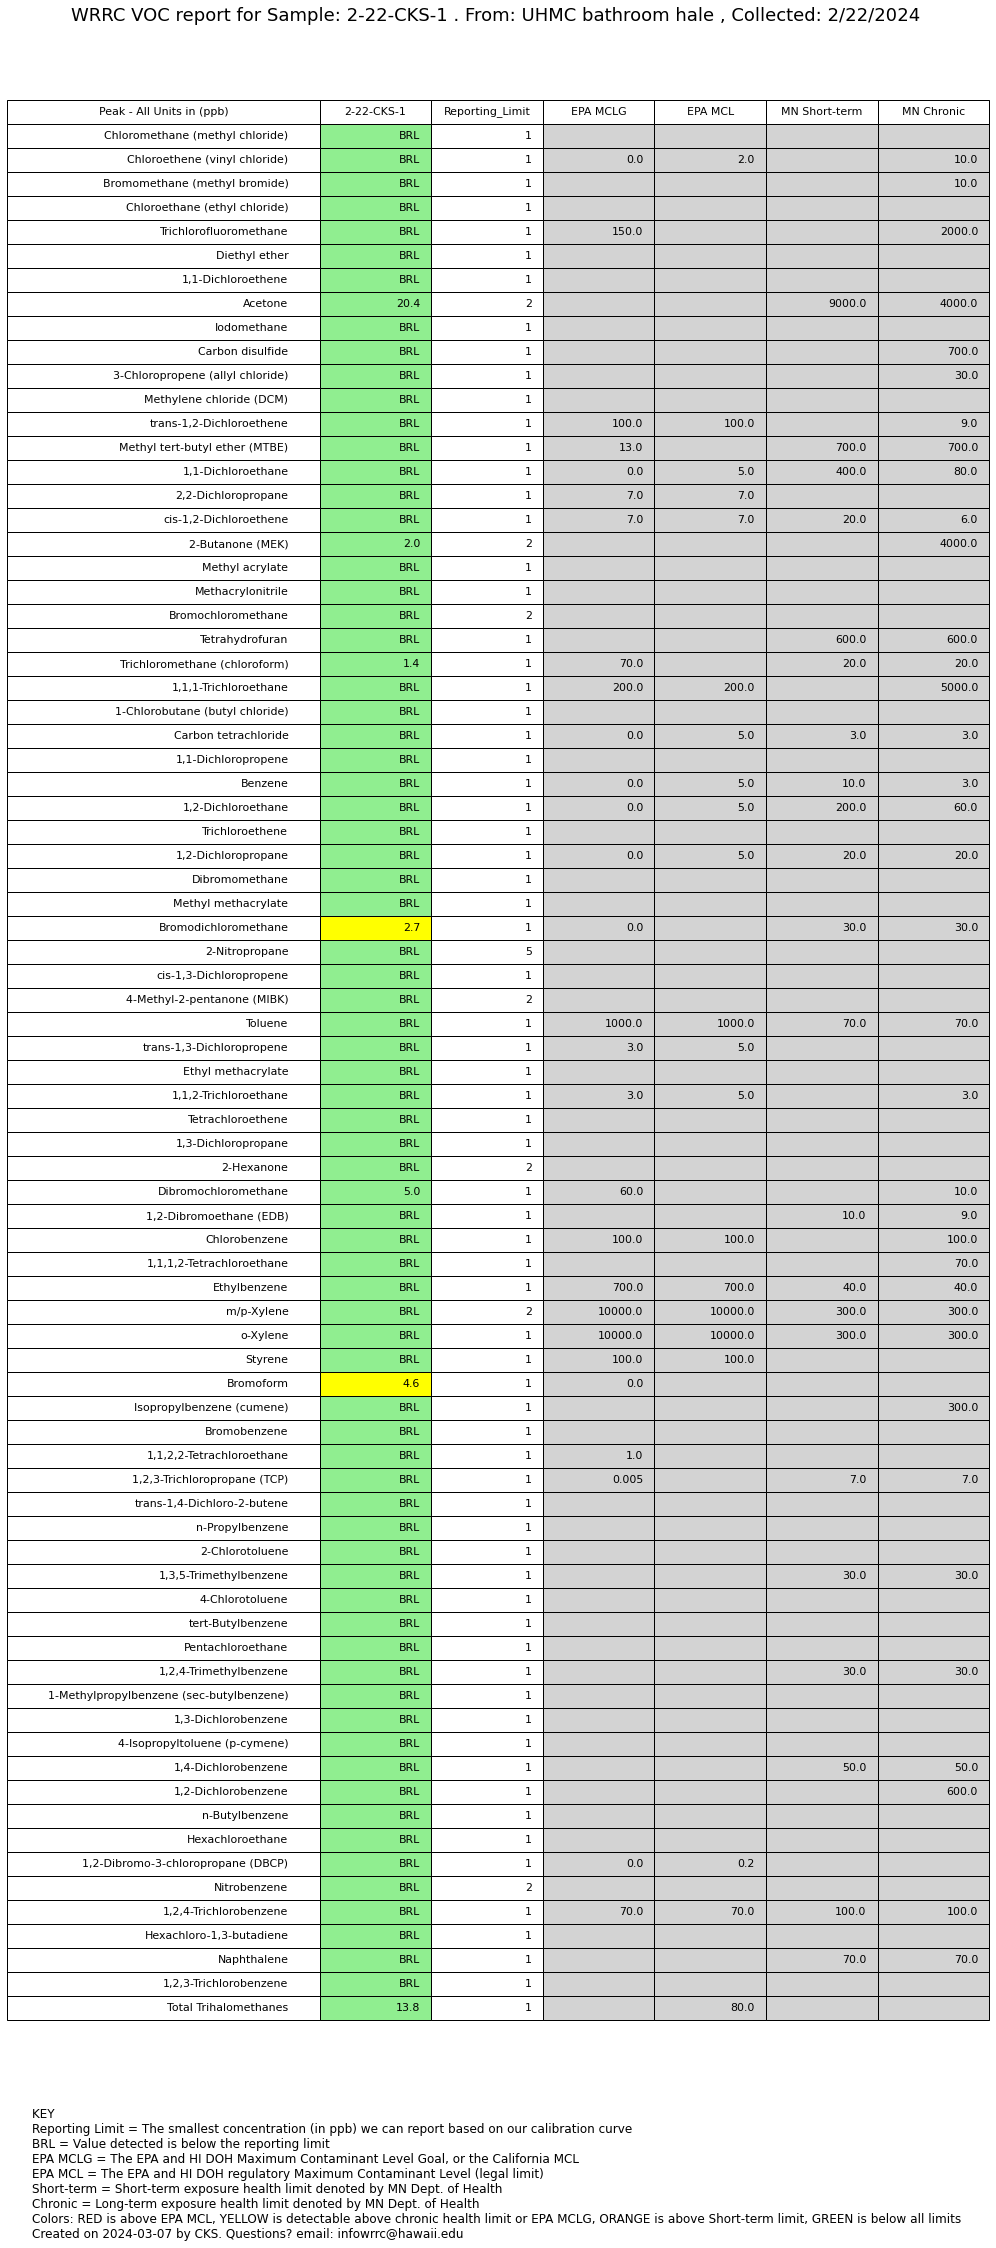

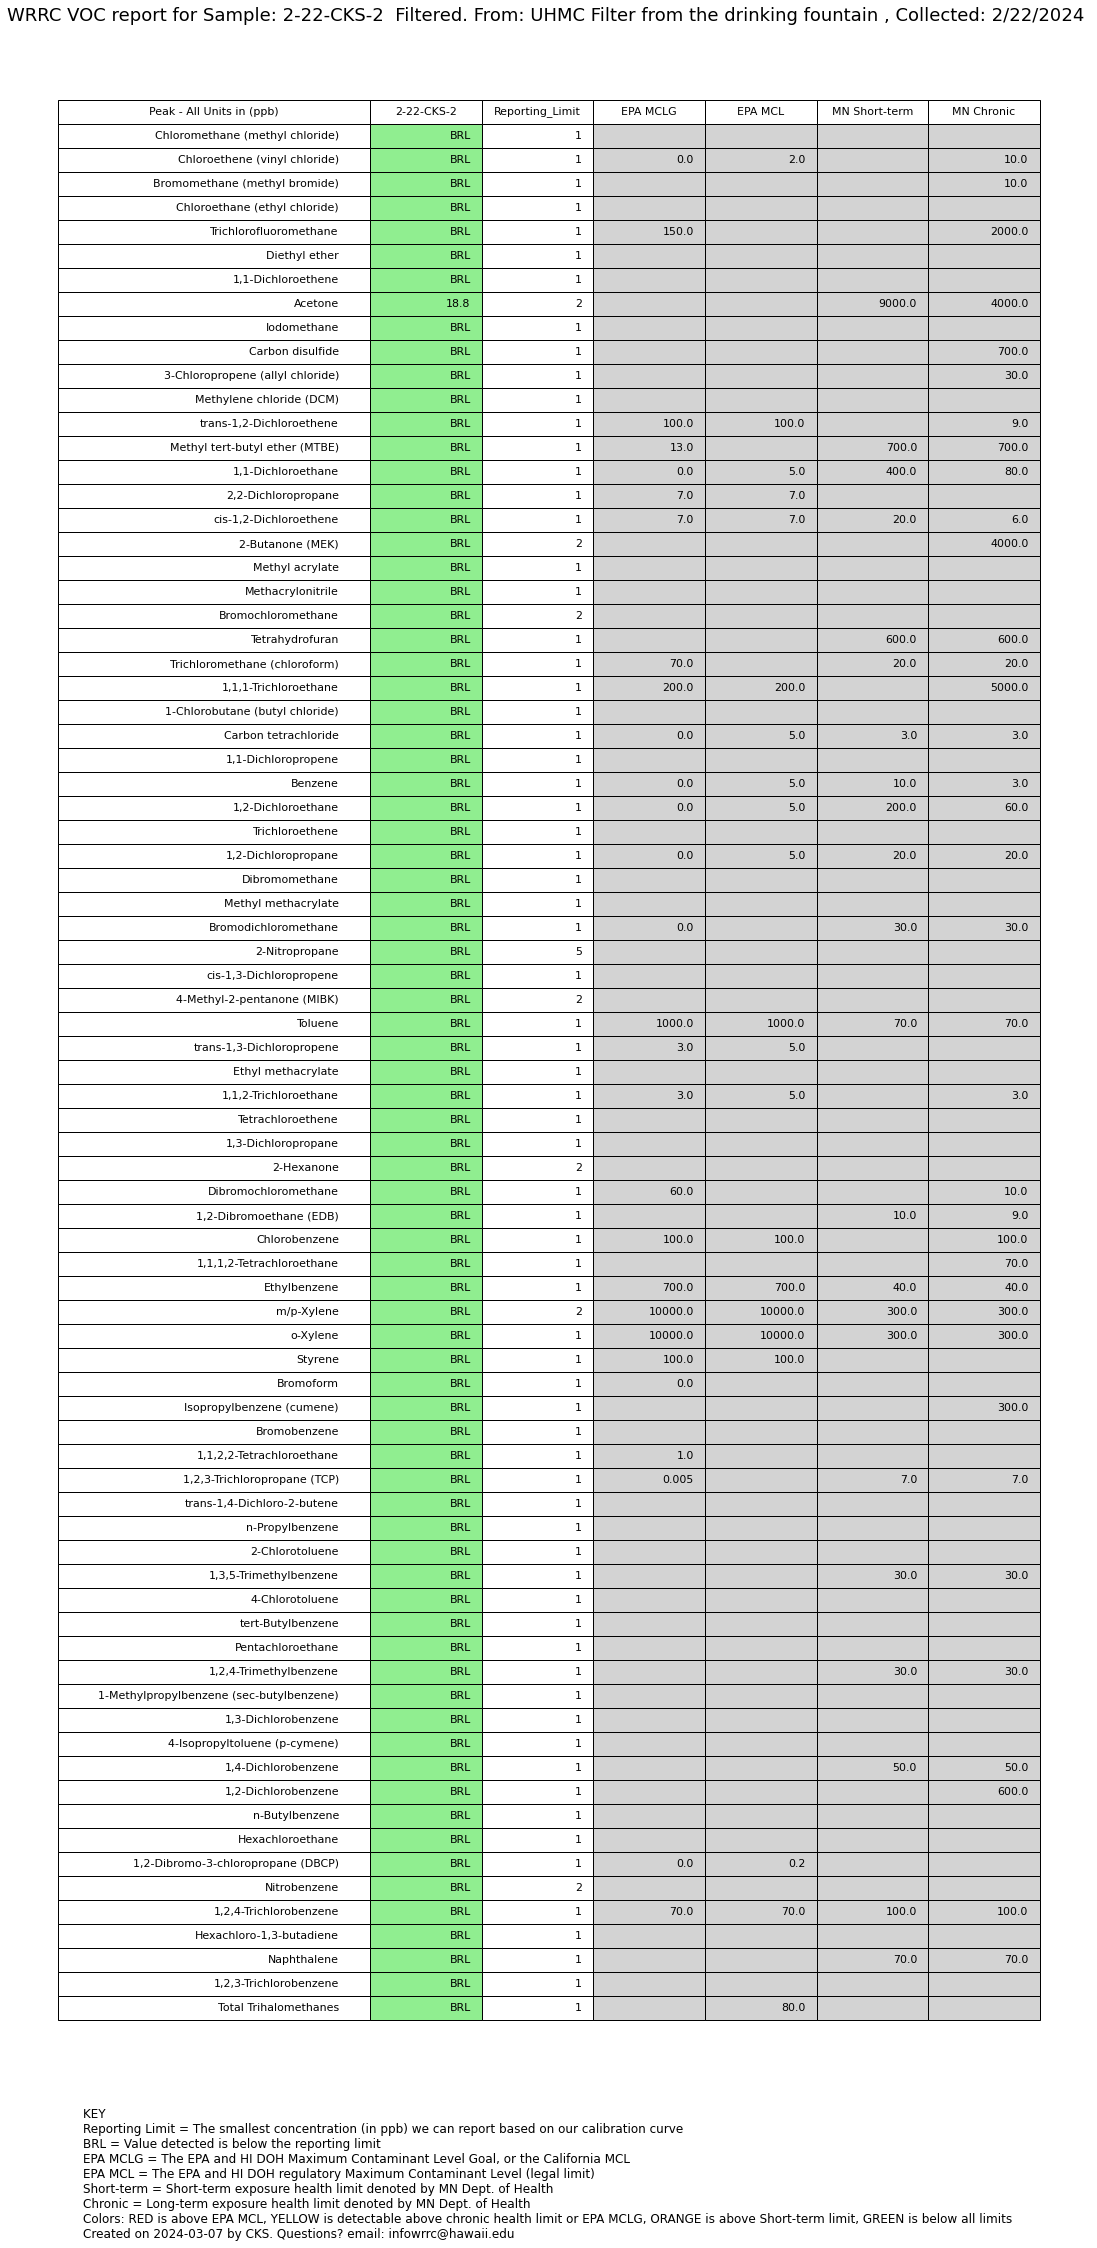

Cannot find address Match for - 01-04-24-JI-01
Cannot find date Match for - 01-04-24-JI-01
Cannot find type Match for - 01-04-24-JI-01


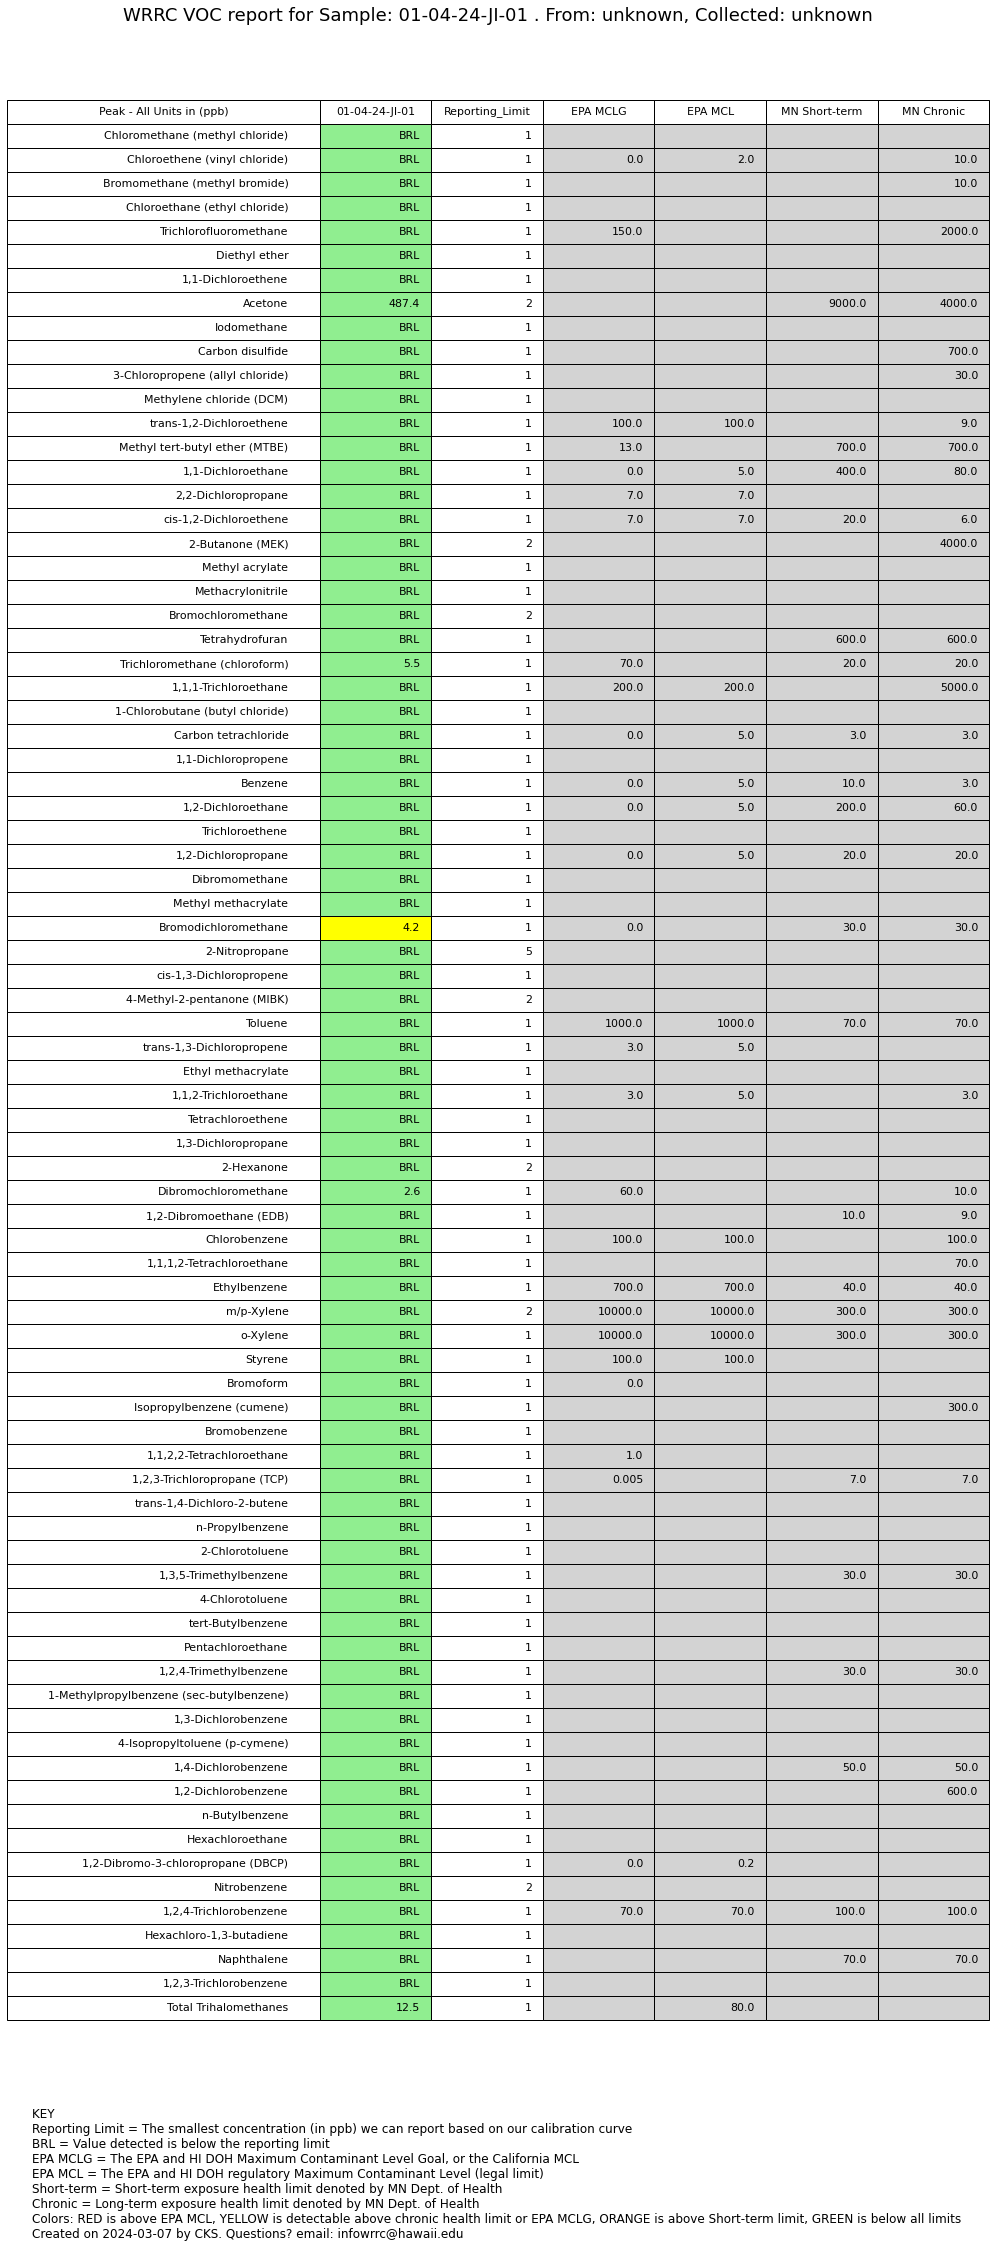

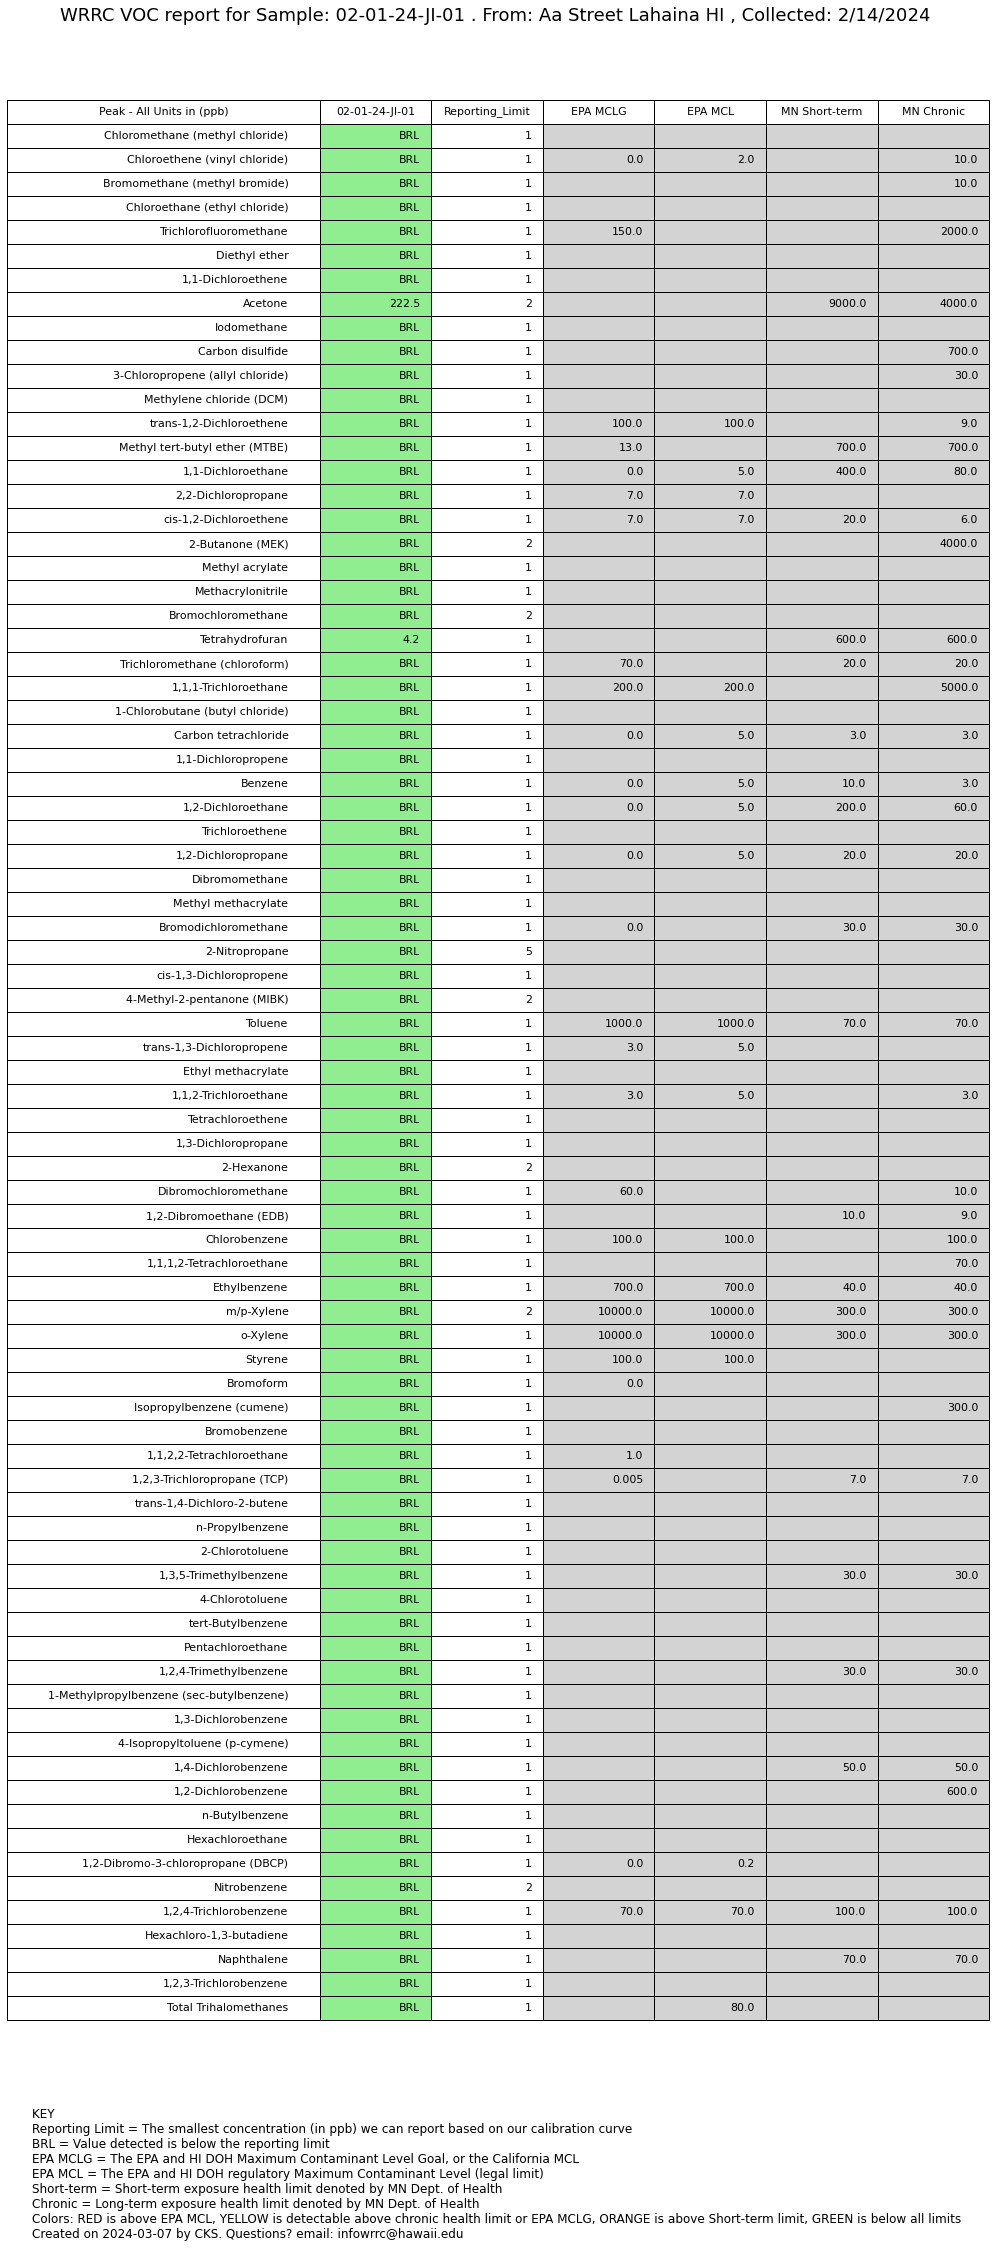

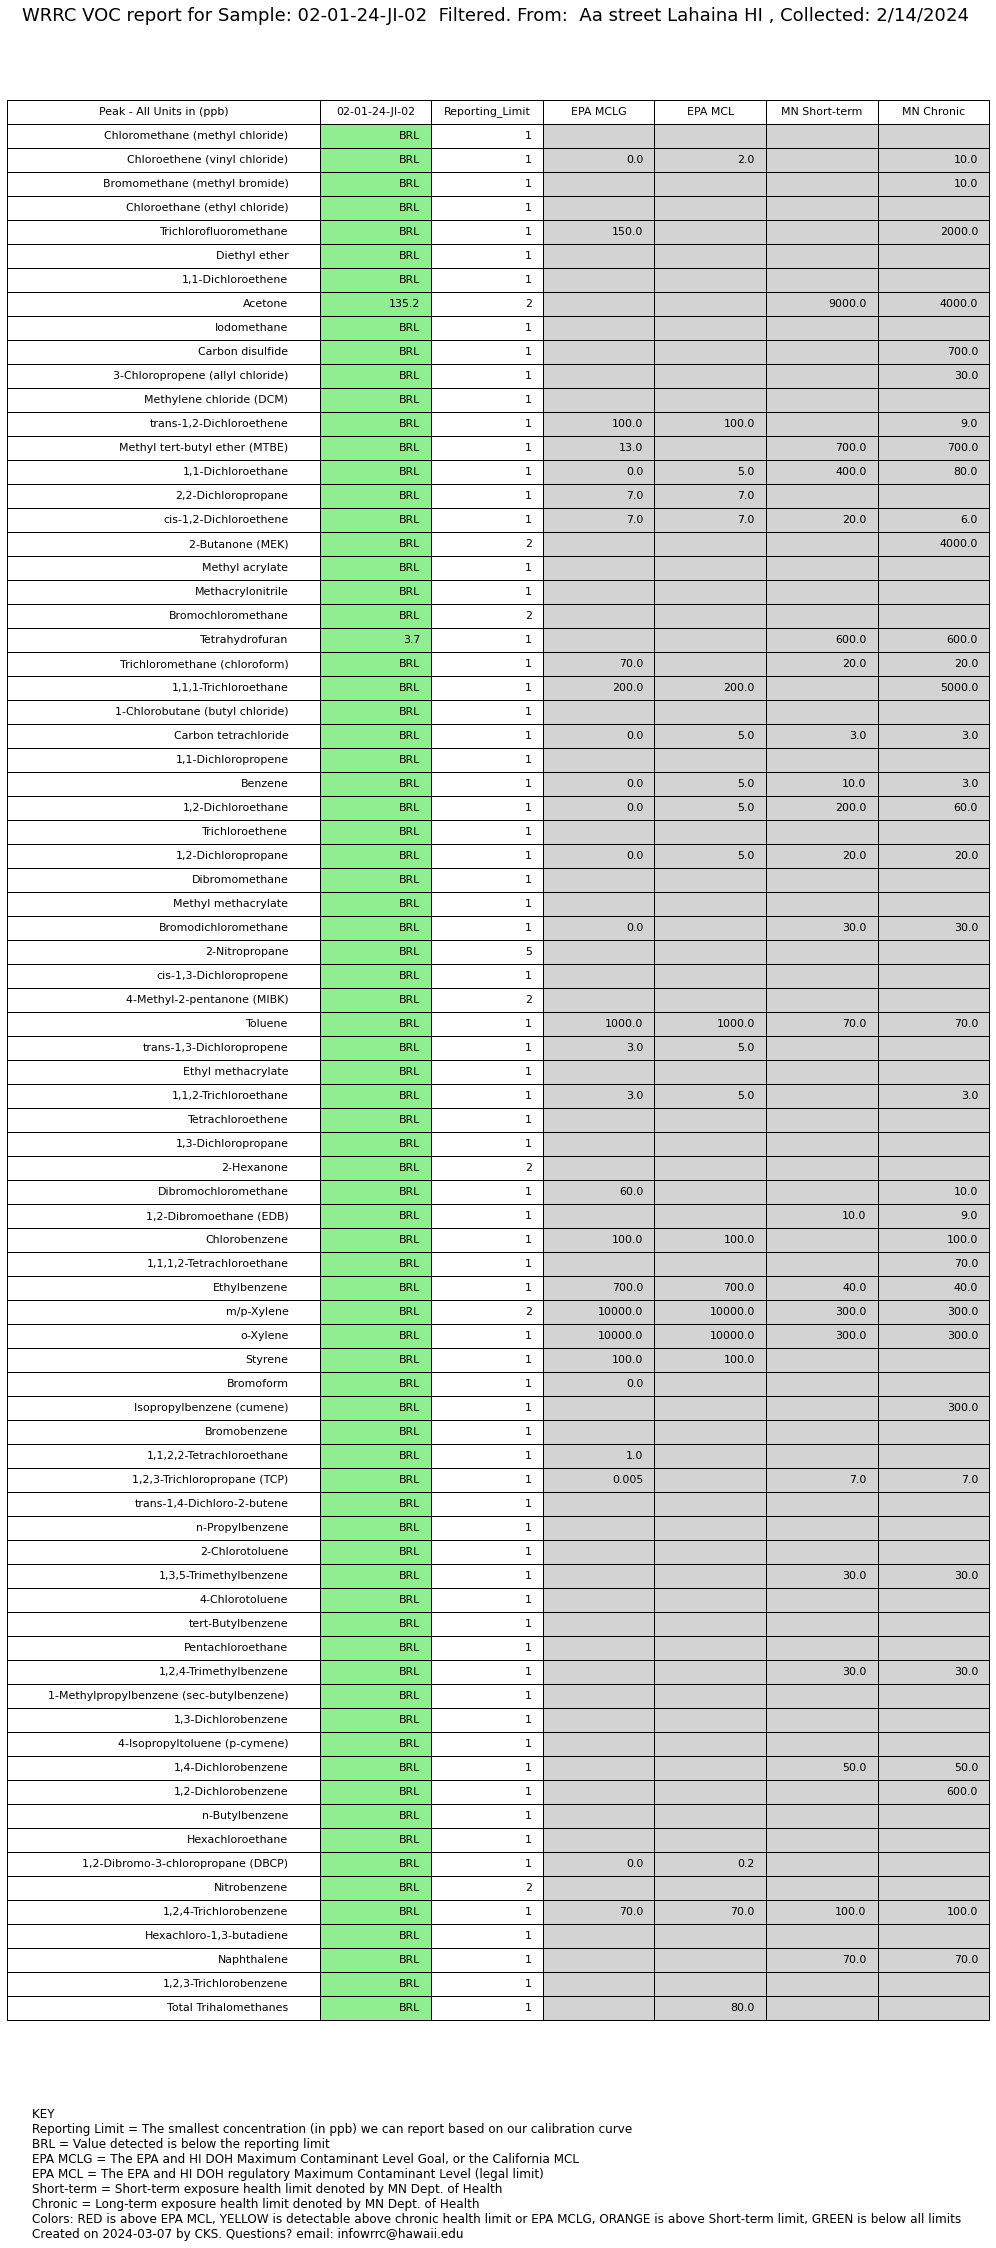

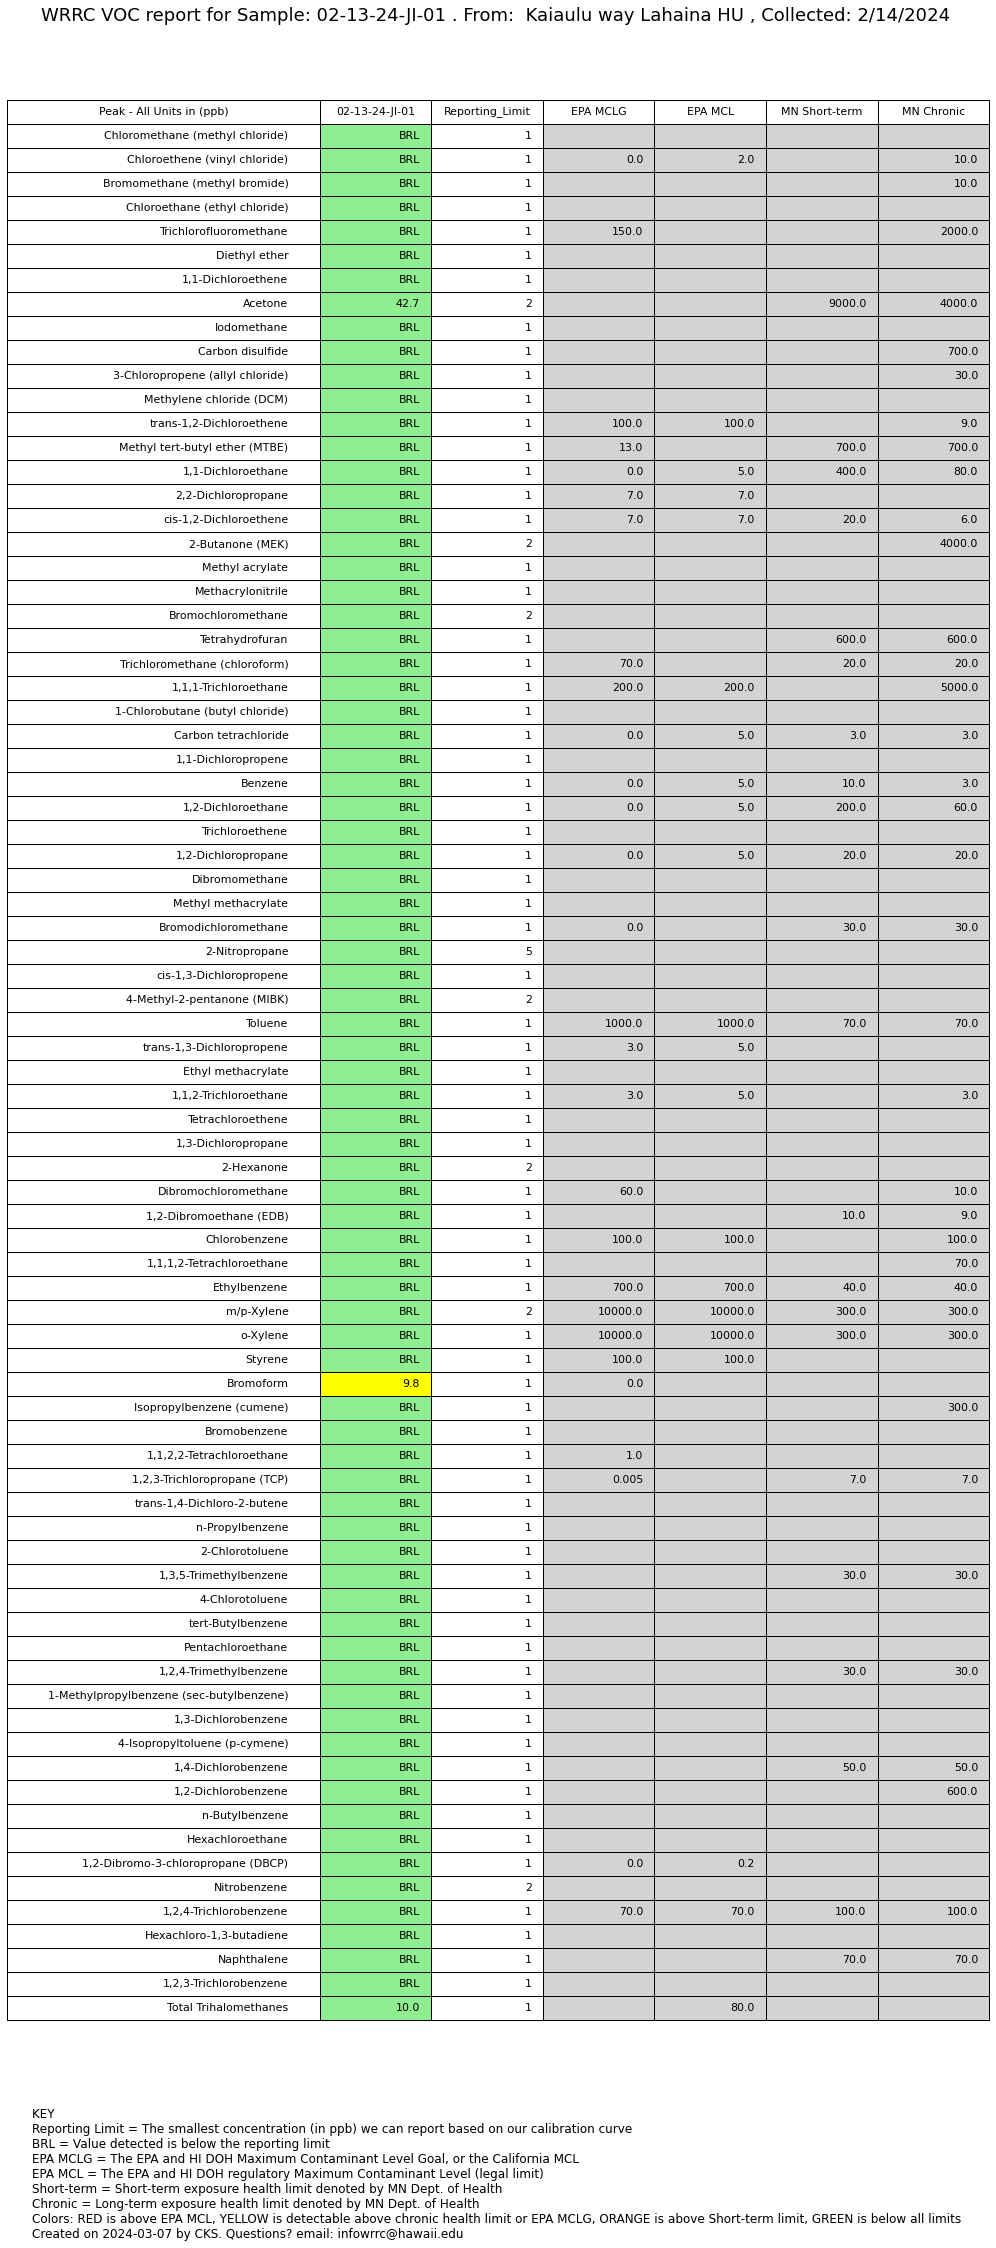

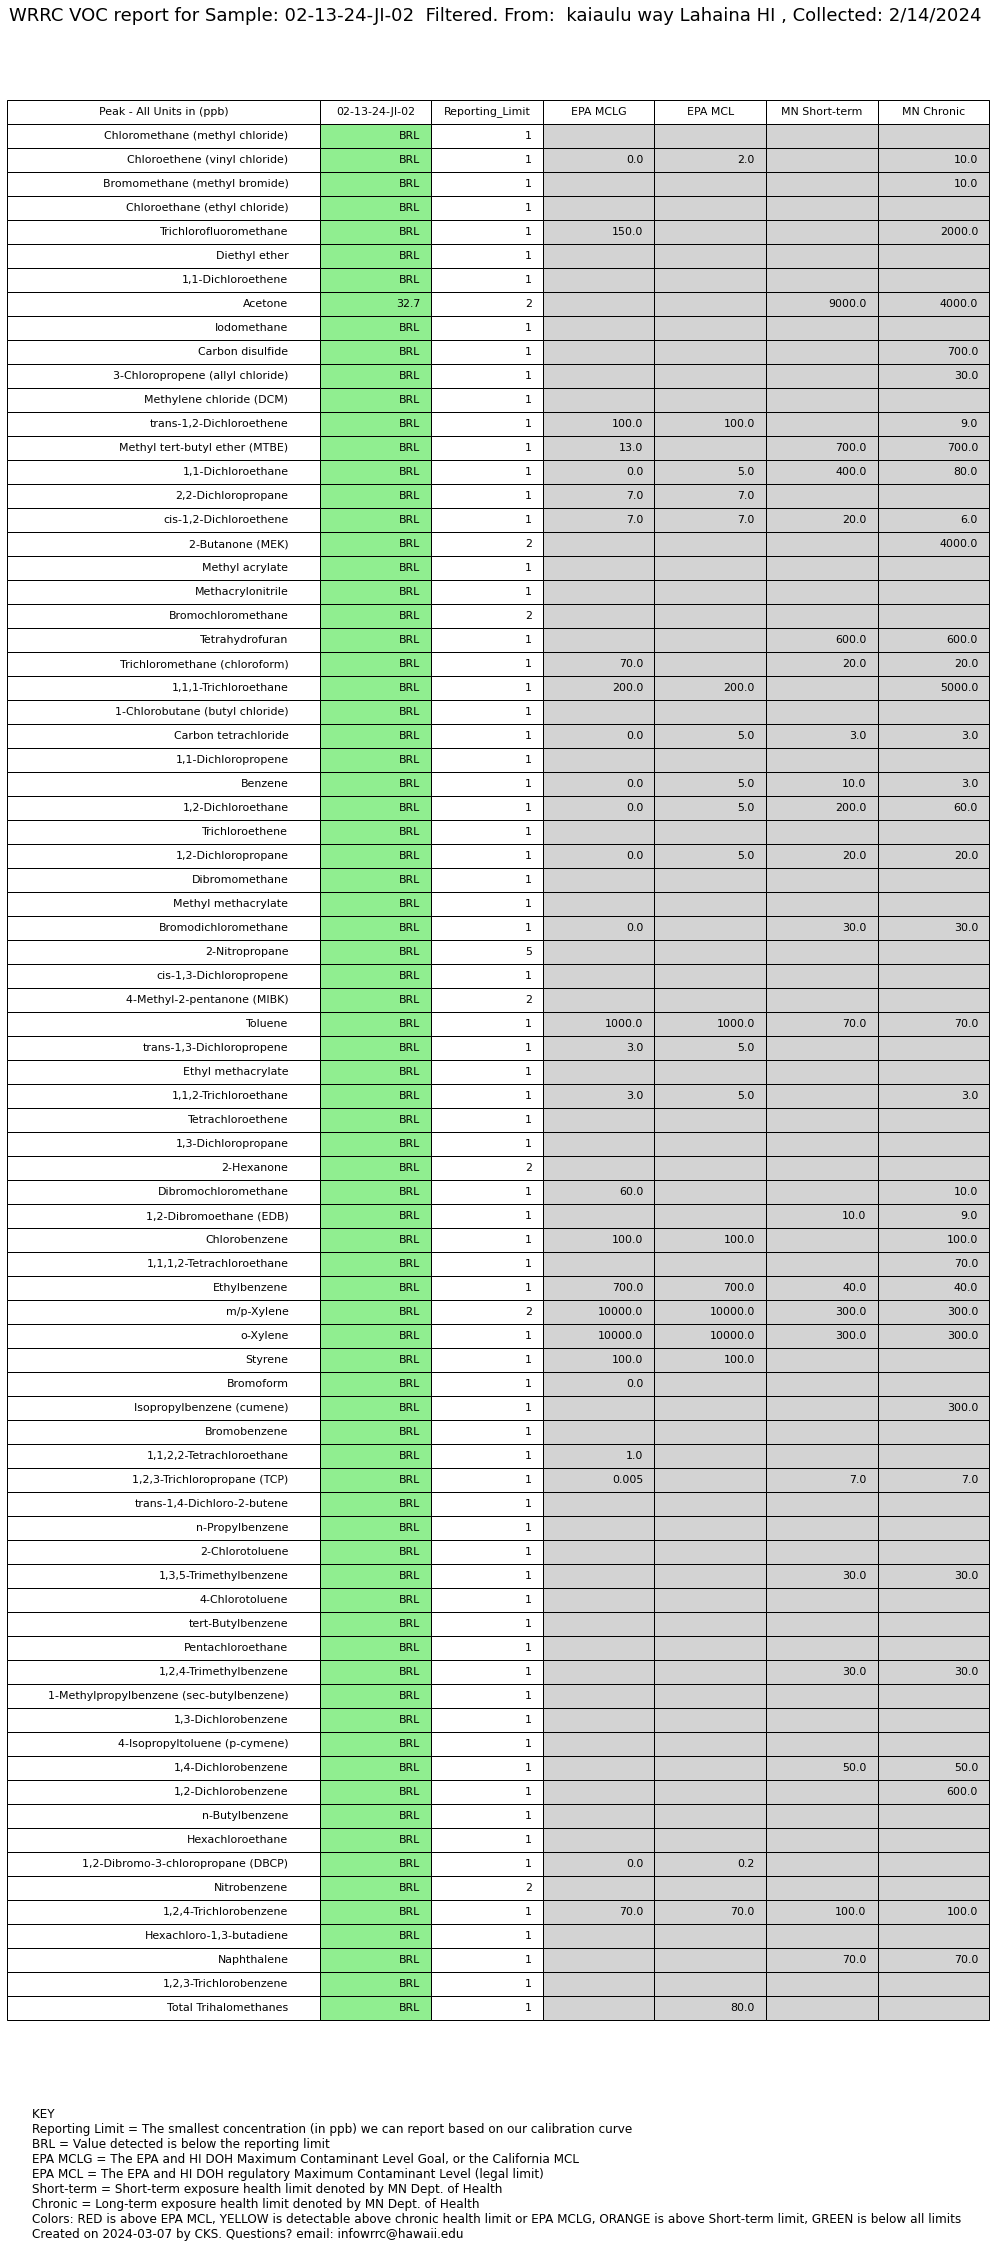

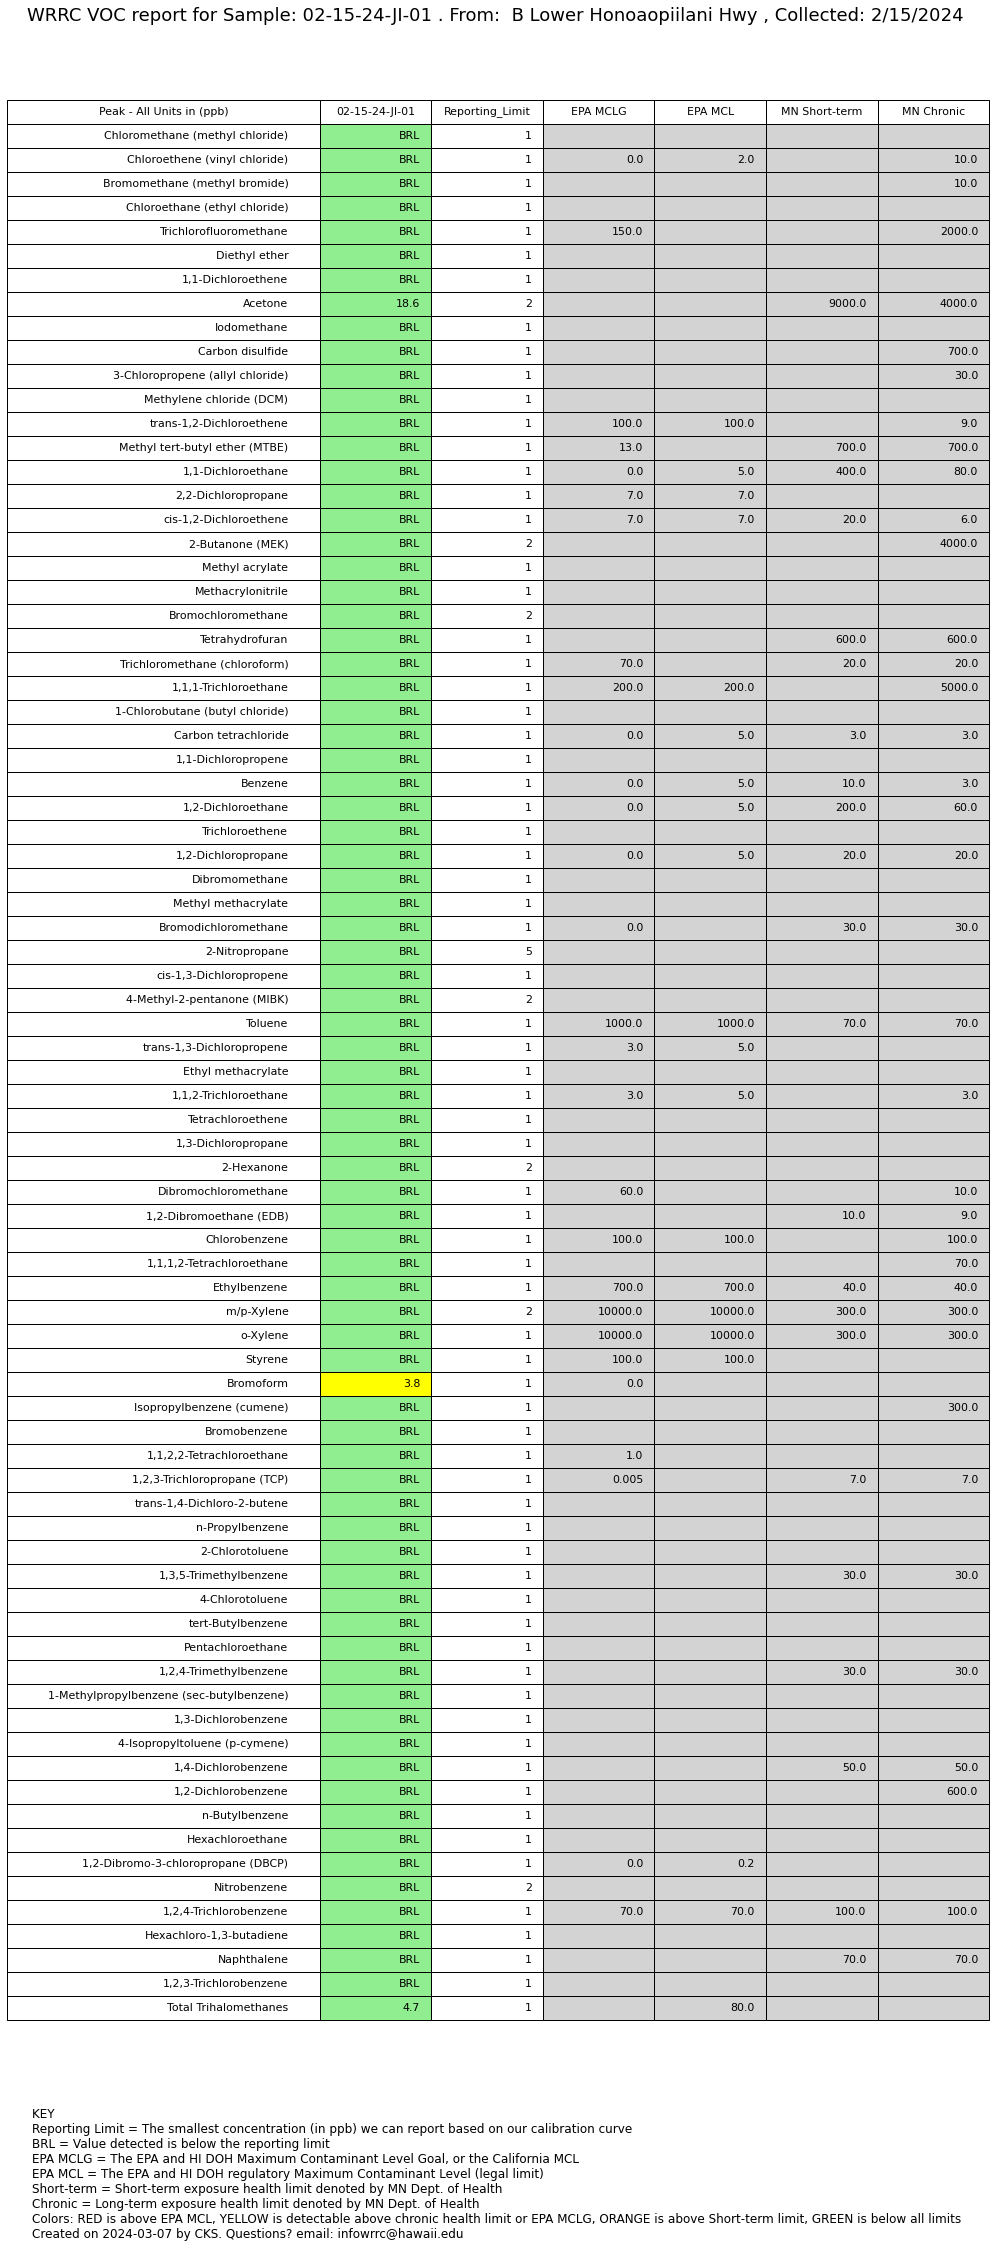

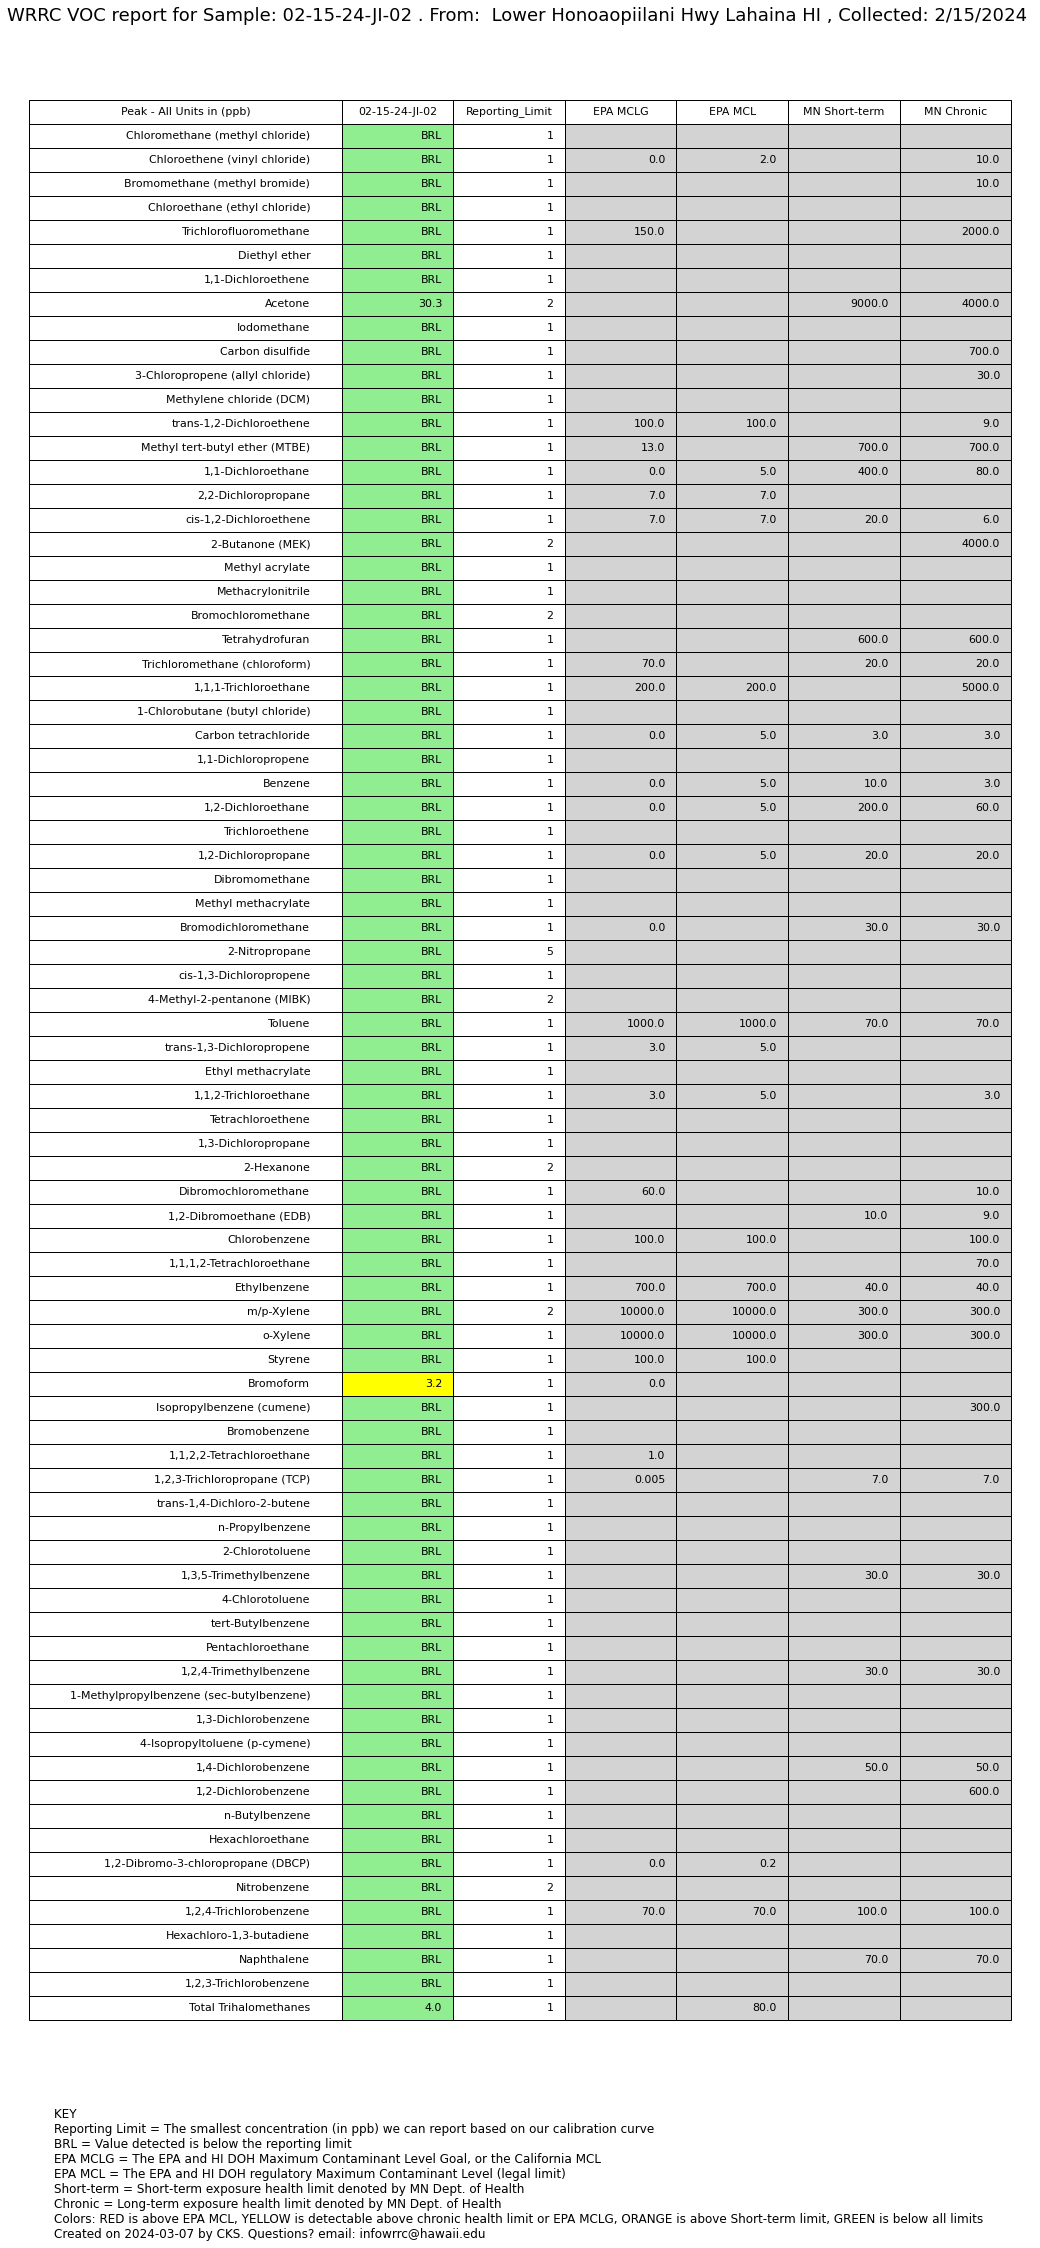

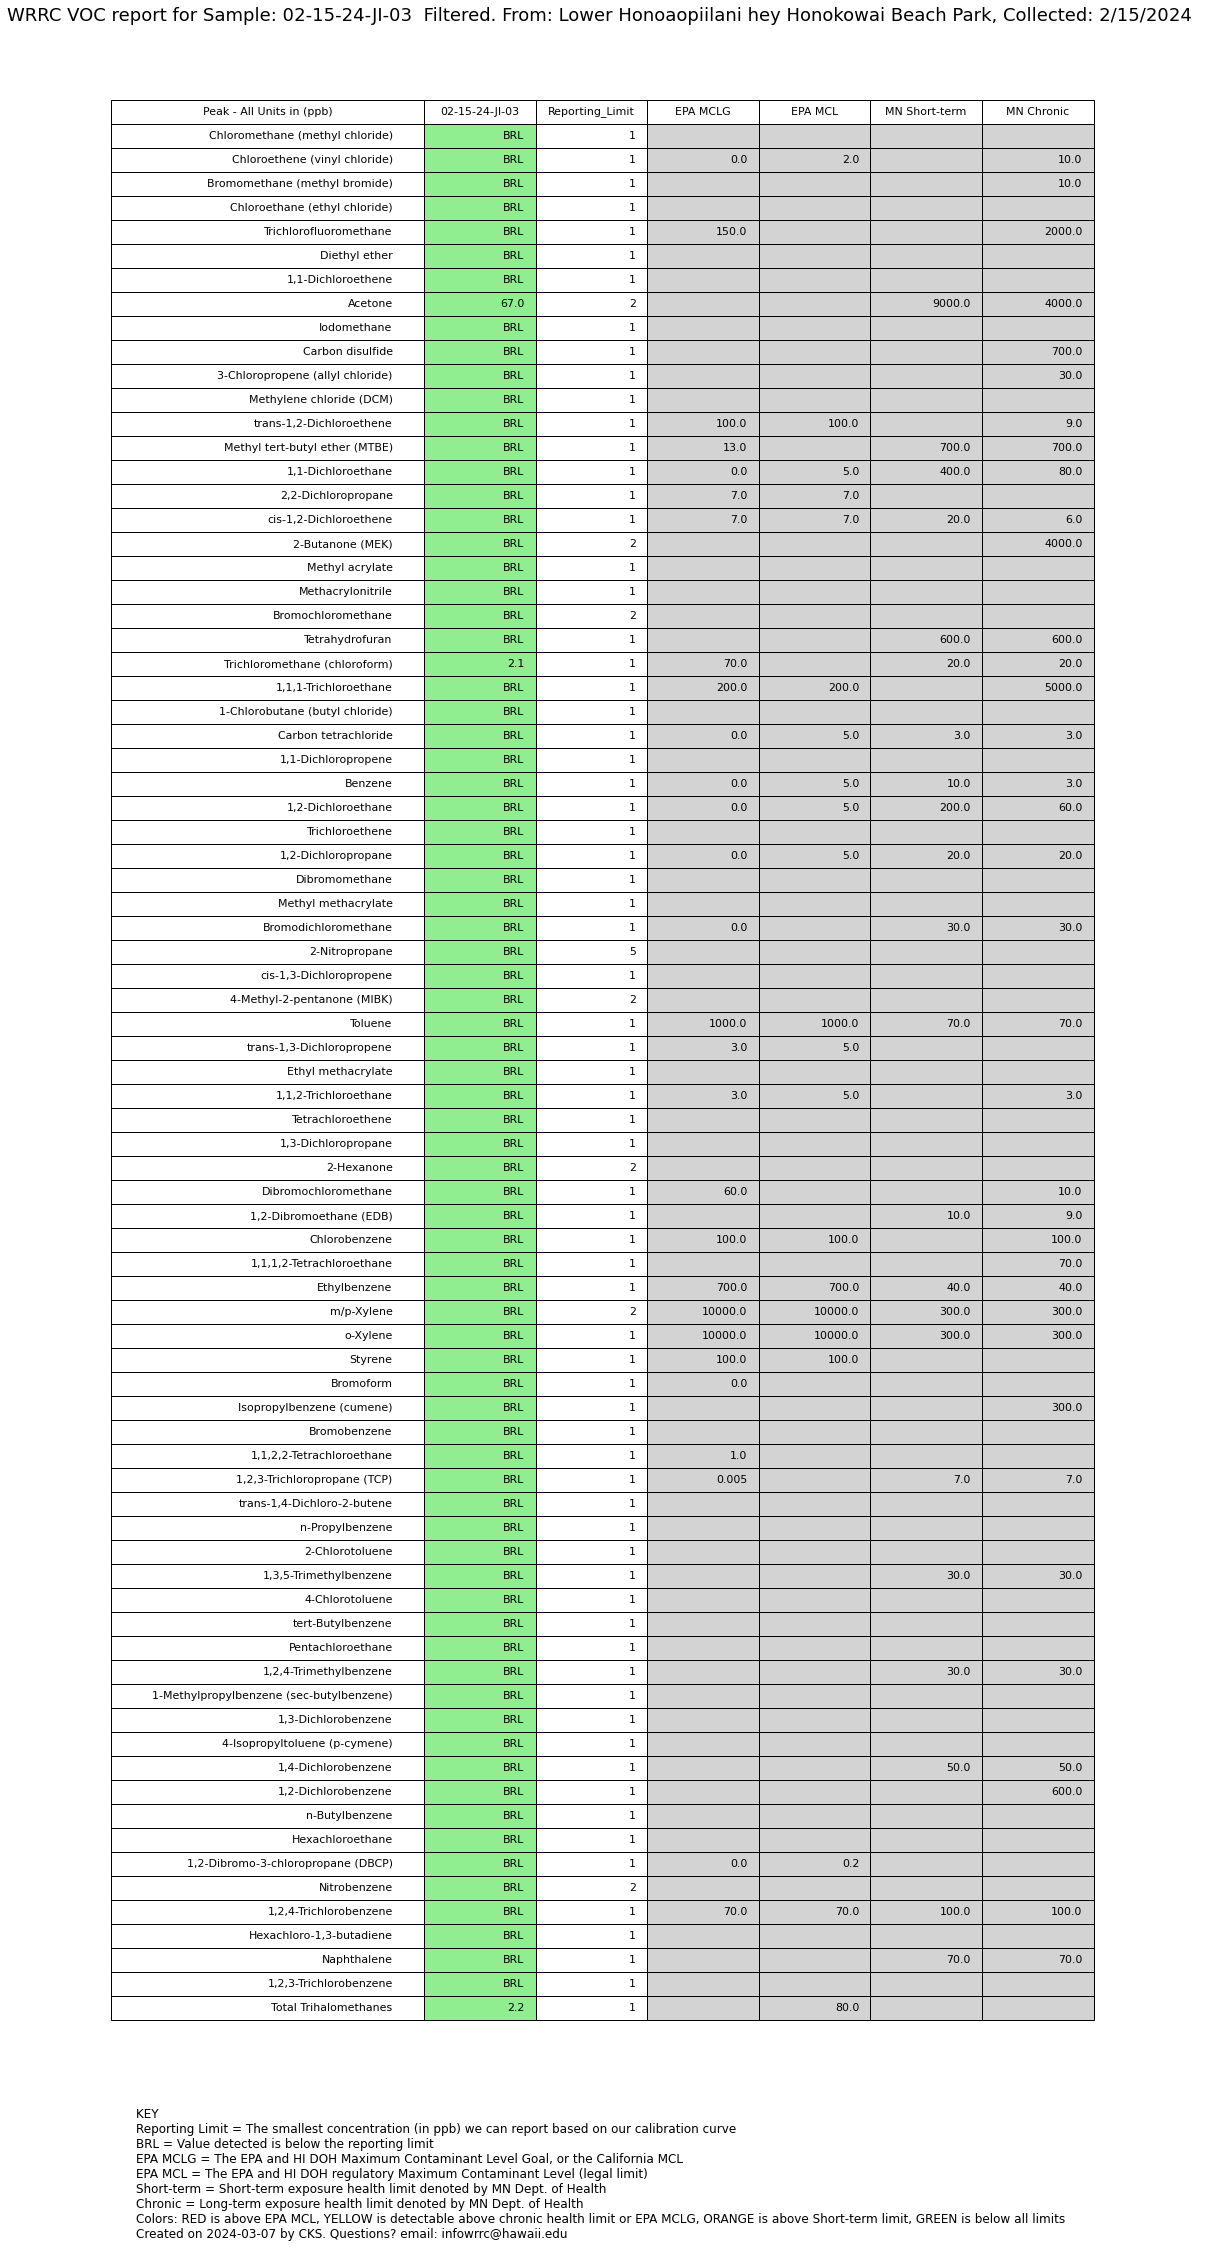

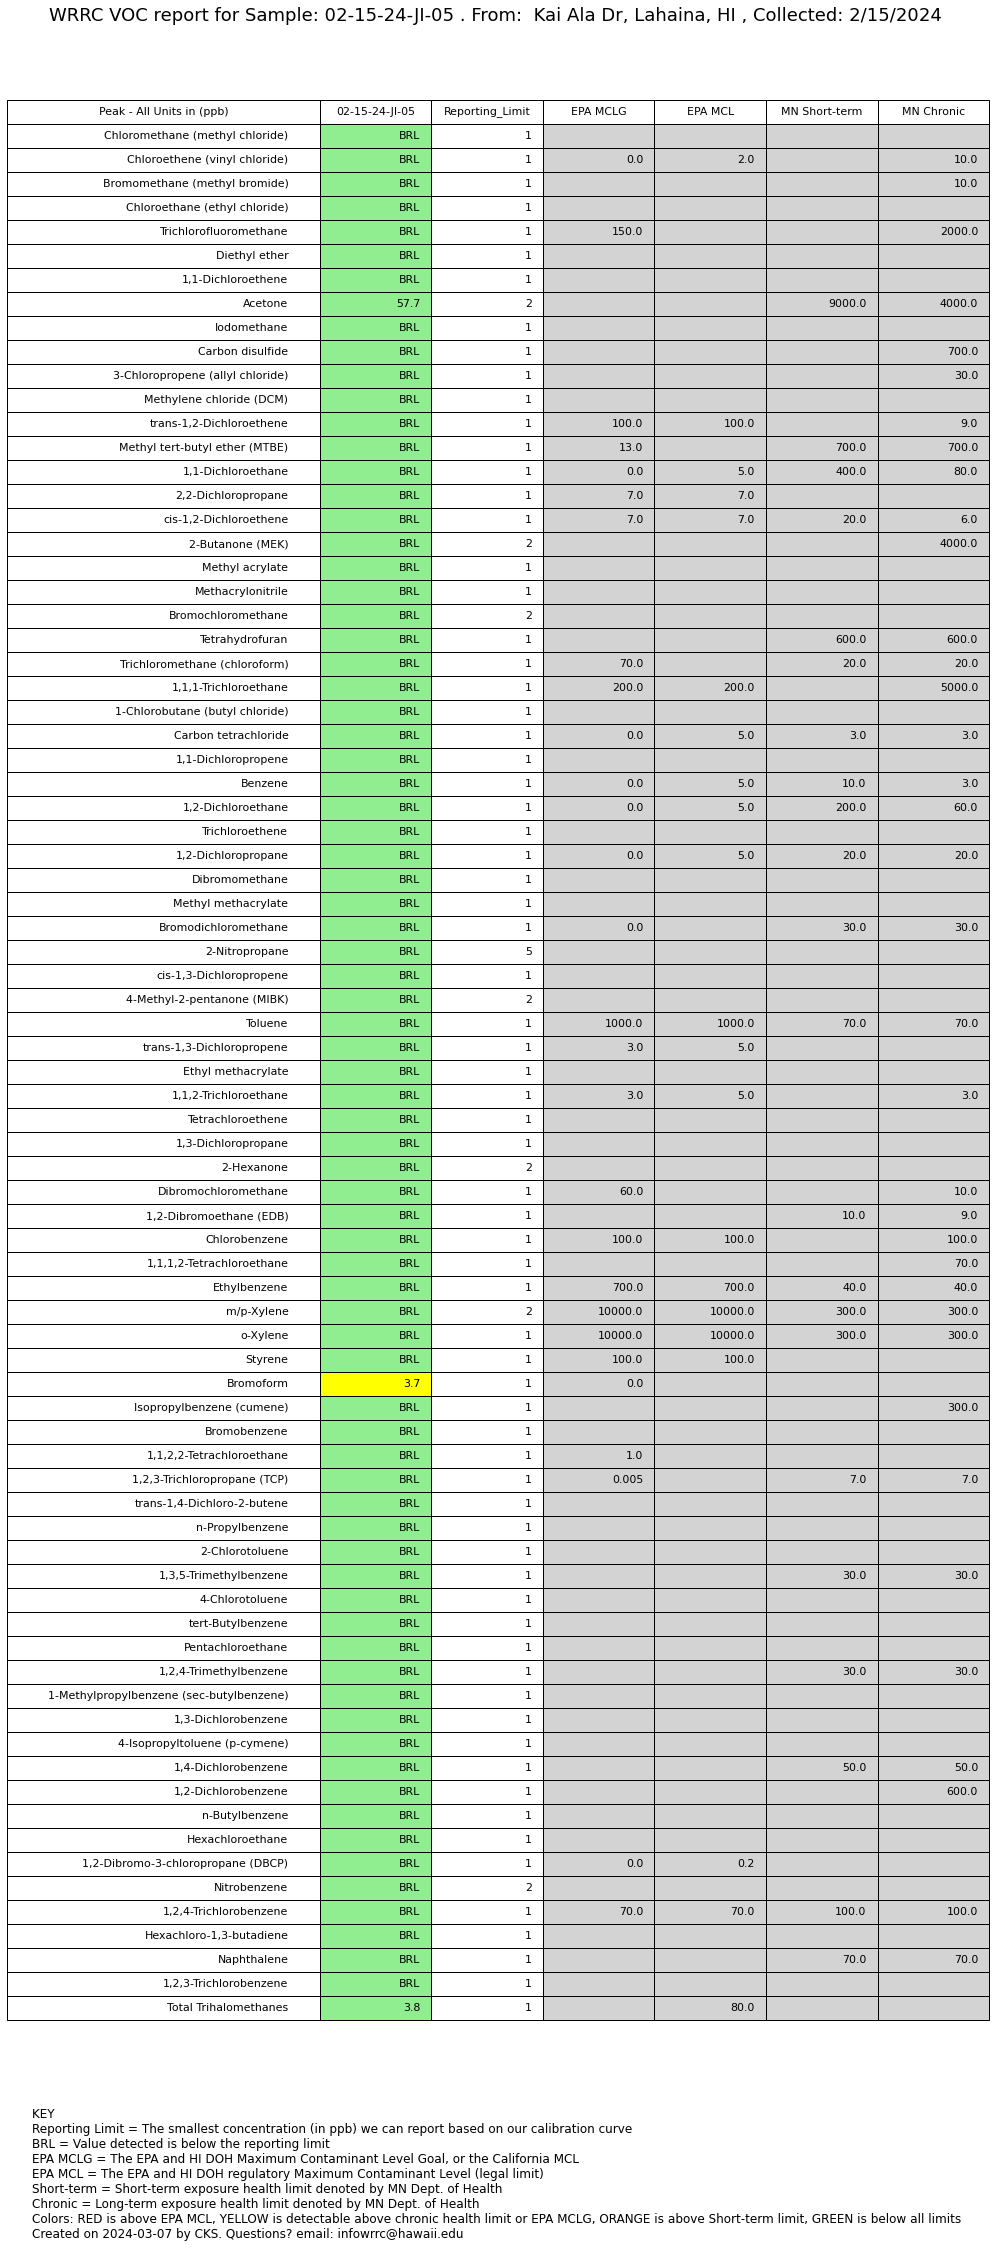

Cannot find date Match for - 02-15-24-JI-06
Cannot find type Match for - 02-15-24-JI-06


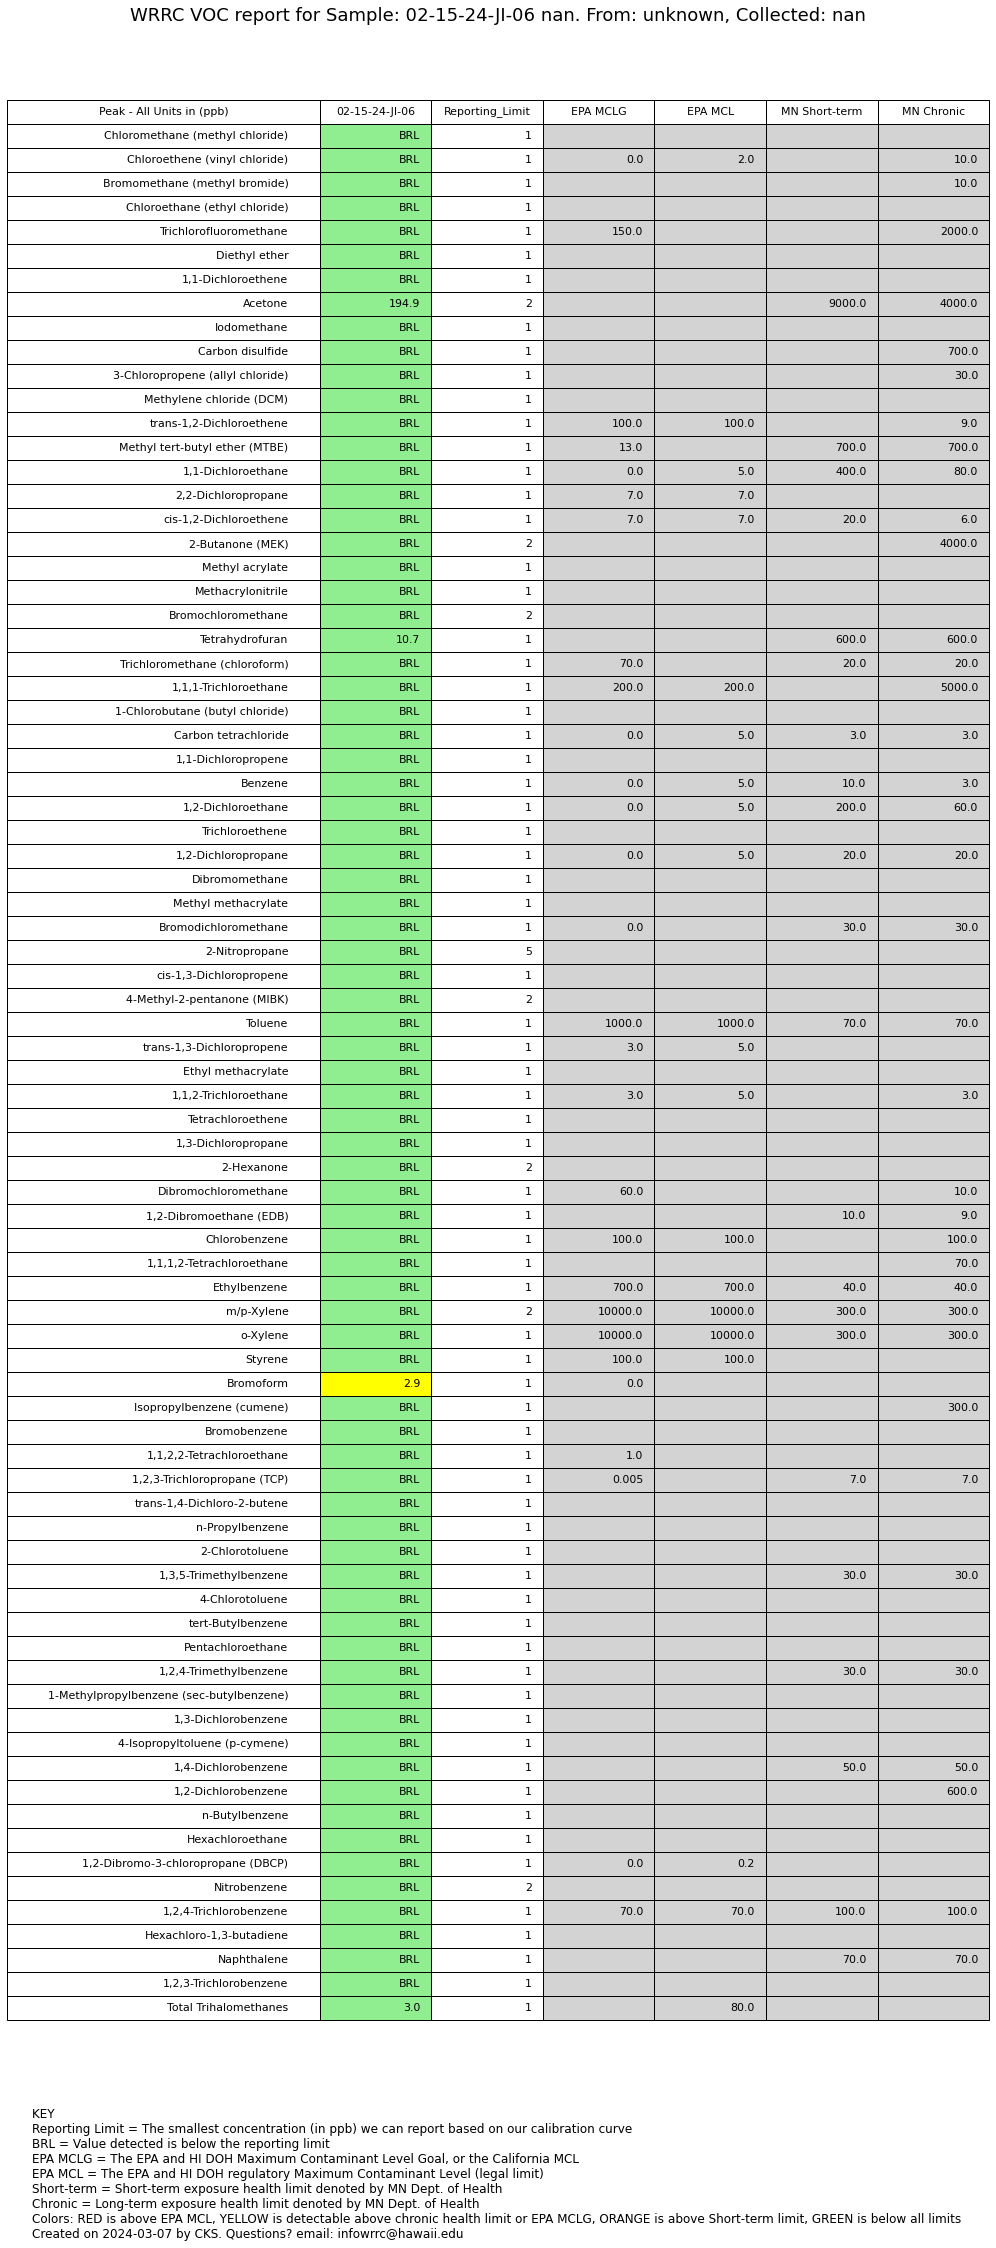

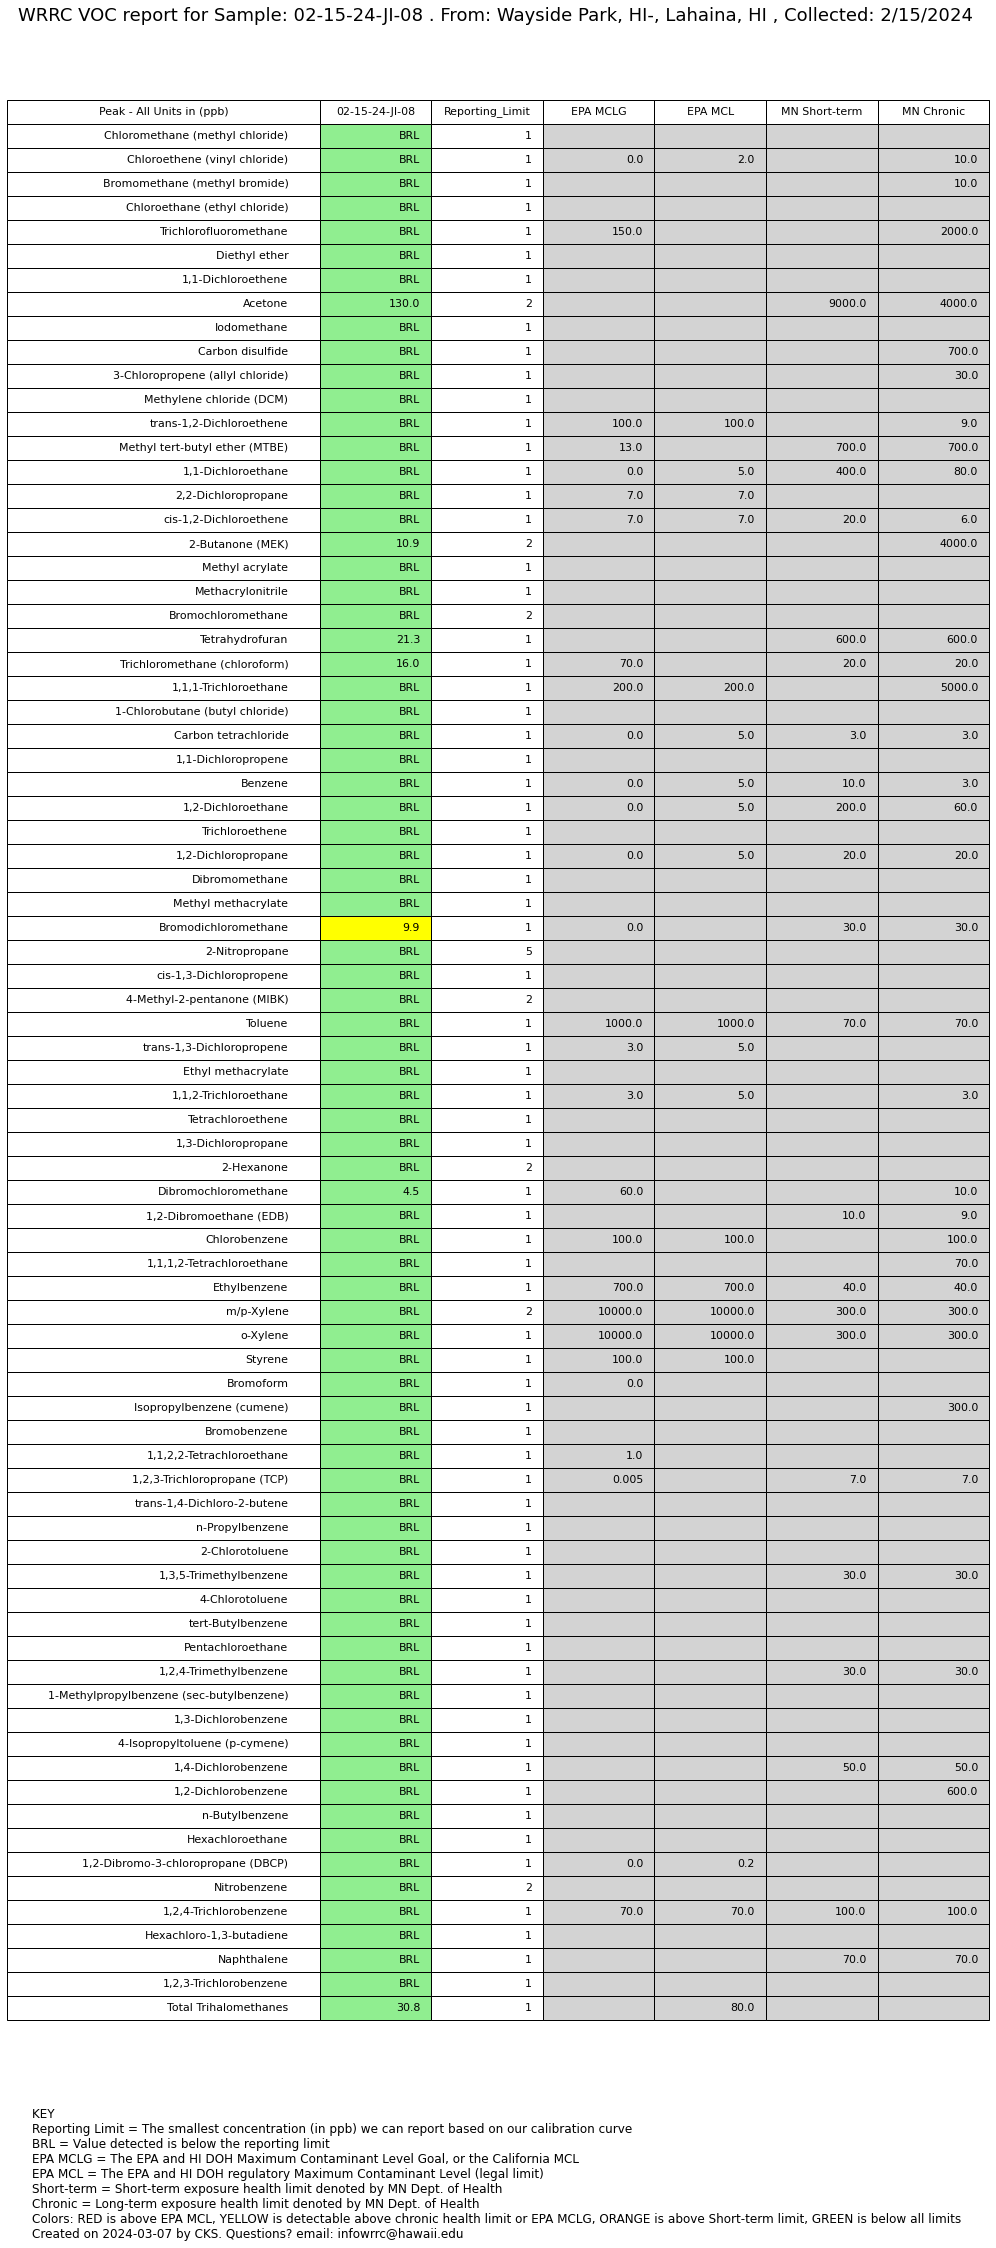

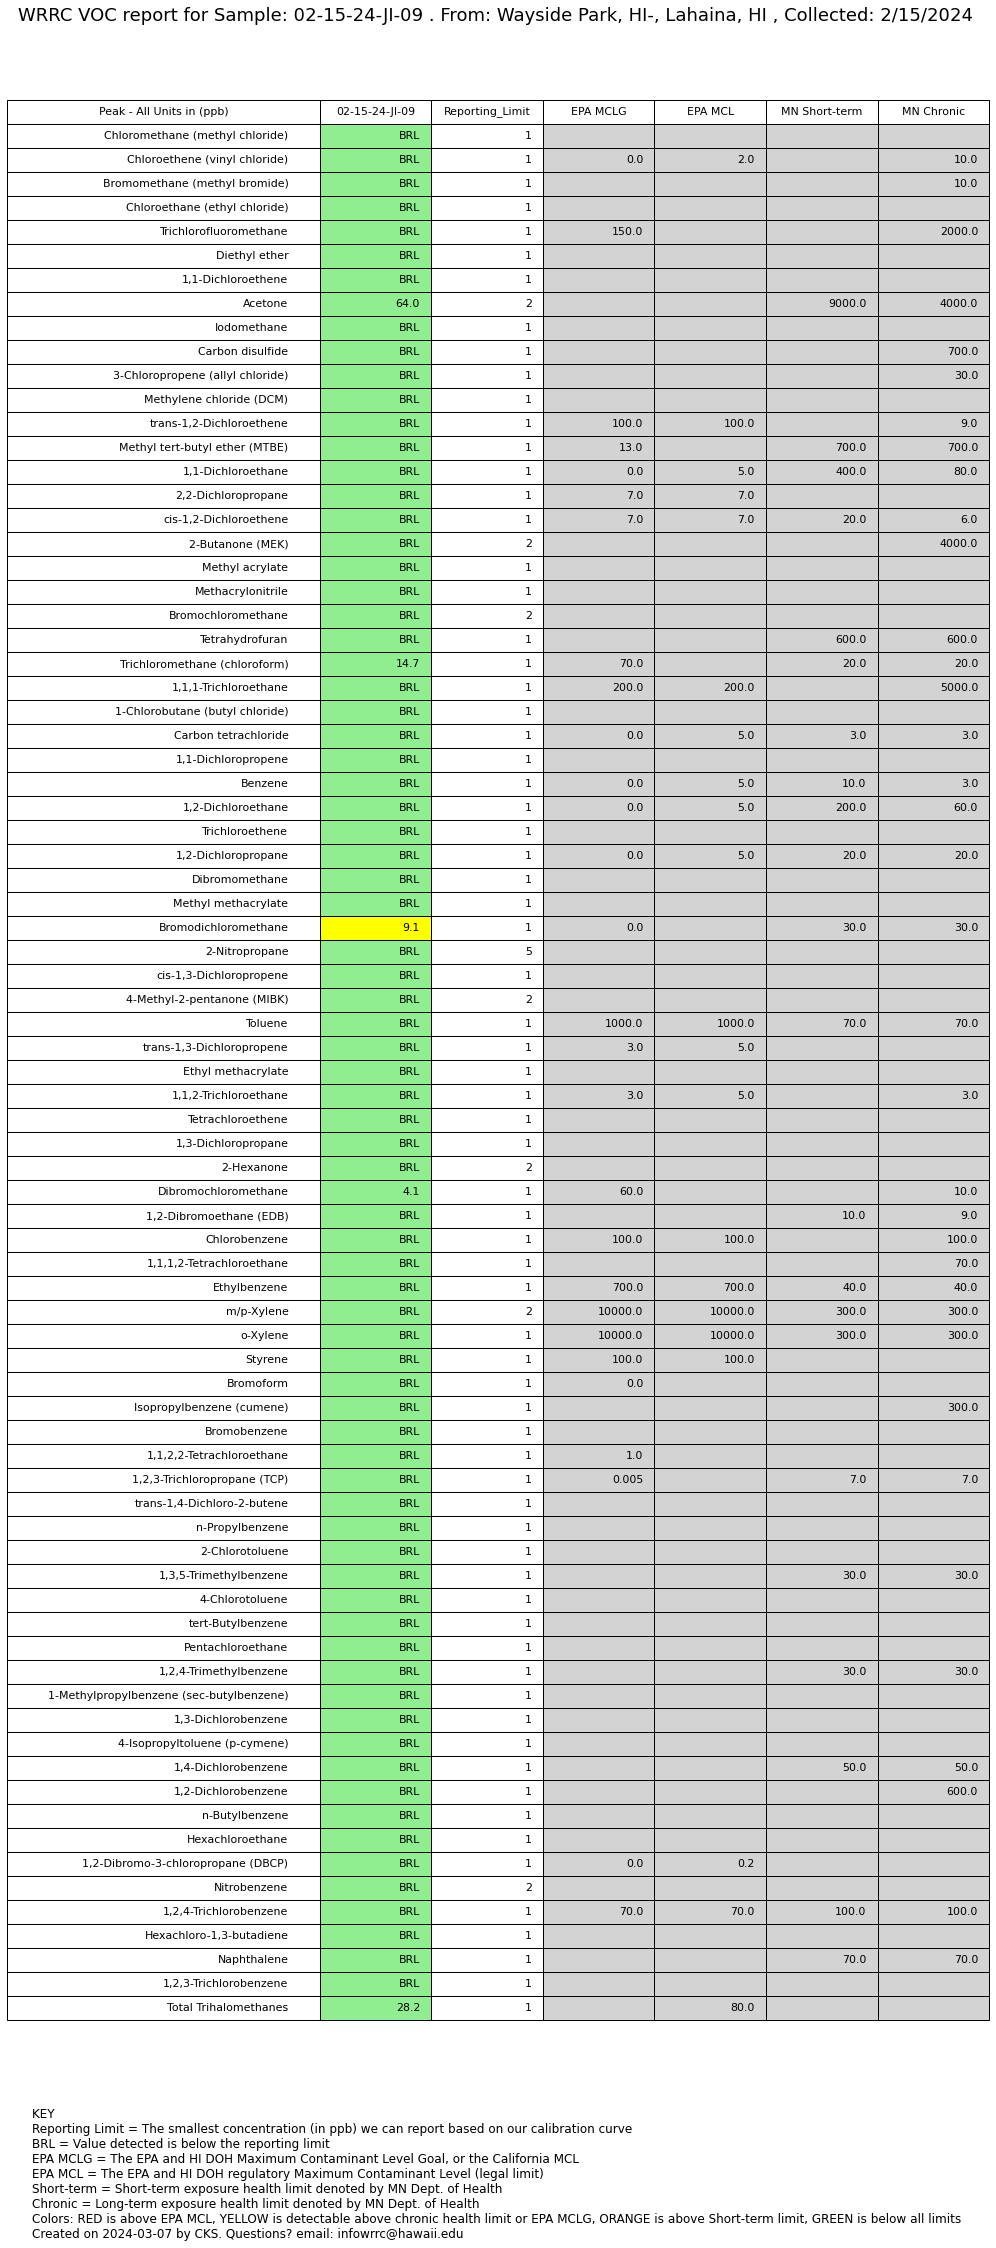

In [43]:
for dataFile in os.listdir(os.path.join("..", "Clean_Data")):

    AllData = Round_3_data_read(os.path.join("..", "Clean_Data", dataFile), PeakColName)
    
    for samp in AllData.columns[2:]: 
        Samp_name = samp
        
        # Read in one sample and stack it up against health limits 
        SampData = One_Sample_DF(Samp_name, AllData, PeakColName, limits, Limits_Peak_col_name)
        
        # Pull  the address and date from the metadata sheet
        address = extract_metadata_address(Samp_name, Metadata_Sheet)
 
        try: 
            address = re.sub('[0-9]', '', address)   # Pull out all the numbers from the addresses 
        except: 
            address = "unknown"
        Samp_Date = extract_metadata_date(Samp_name, Metadata_Sheet)
        typo = extract_metadata_type(Samp_name, Metadata_Sheet)
        
        
        # Print off our tables 
        the_table = FancyTable(SampData, Samp_name, address, Samp_Date, typo)   

# Tools 


In [ ]:
## Loop over list of all sample names in clean folder 

for datafile in os.listdir(os.path.join("..", "Clean_Data")):
    
    AllData = pd.read_csv(os.path.join("..", "Clean_Data", datafile))
    print(AllData.columns[2:])

In [ ]:
OLD 

for datafile in os.listdir(os.path.join("..", "Clean_Data")):

    AllData = Round_3_data_read(os.path.join("..", "Clean_Data", dataFile), PeakColName)
    
    for samp in AllData.columns[2:]: 
        Samp_name = samp
        
        # Read in one sample and stack it up against health limits 
        SampData = One_Sample_DF(Samp_name, AllData, PeakColName, limits, Limits_Peak_col_name)
        # Pull  the address and date from the metadata sheet
        address = extract_metadata_address(Samp_name, Metadata_Sheet)
        #address = re.sub('[0-9]', '', address)   # Pull out all the numbers from the addresses 
        date = extract_metadata_date(Samp_name, Metadata_Sheet)
        
        # Print off our tables 
       # the_table = FancyTable(SampData, Samp_name, address, date)   
    print(address)
    
    
    
    

    
def randomizor():
    # Generate random numbers we need between +-.001 and +-.002
    randomLat = random.uniform(0.001, 0.002)
    randomLon = random.uniform(0.001, 0.002)
    random_choice = random.choice([-1, 1])
    
    return (randomLat, randomLon, random_choice)
    
    
    
    
SampData = AllData[[PeakColName, Samp_name, 'Reporting_Limit']].copy()  # 'LLOQ/MRL'
# Add a spacer column 
#SampData["-"] = ""
SampData


# Add on the health limits from their dataframe 
for limNam in Wanted_Limits_List:
    # Make a dictionary of the peak name and the health limit for that peak, iterative over various health limits
    lim_dict = dict(zip(limits[Limits_Peak_col_name], limits[limNam]))
    # The magic - match up the limit to its appropriate row in the sample data 
    SampData[limNam] = SampData[PeakColName].apply(lambda x: lim_dict.get(x))

# # Turn text into nans     
SampData[Samp_name] = pd.to_numeric(SampData[Samp_name], errors='coerce')
SampData['Reporting_Limit']   = pd.to_numeric(SampData['Reporting_Limit'] , errors='coerce')




#Scrub out values that are below reporting limit
SampData[Samp_name] = np.where(SampData[Samp_name] < SampData['Reporting_Limit'], np.nan, SampData[Samp_name])

#     # Add the little ppb units explanation
SampData.rename(columns={PeakColName: '{} - All Units in (ppb)'.format(PeakColName)}, inplace=True)

SampData